## 進階機器學習 HW3-2 
#### Develop two models to classify these texts into one of the three possible sentiments.
* 學號: B103040047
* 姓名: 周安

Download nltk data.

In [274]:
# import nltk

# nltk.download()

In [275]:
SOURCE_FILE = "HW3_text.csv"

In [276]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
# from torchsummary import summary
from torchinfo import summary # better for showing LSTM, RNN, CNN model info, which is an improvised version

import pandas as pd

import re 

In [277]:
import random

import torch
import numpy as np

# for reproduce rsult
def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(42)

Load the csv file.

In [278]:
text_df = pd.read_csv(SOURCE_FILE)
print(text_df)
print(text_df["message"][583])

                                               message sentiment
0                           I really enjoyed the movie  positive
1                                The food was terrible  negative
2                   I'm not sure how I feel about this   neutral
3                            The service was excellent  positive
4                               I had a bad experience  negative
..                                                 ...       ...
579  I have to cancel my vacation plans because I c...  negative
580  My computer crashed and I lost all my importan...  negative
581  I got into a car accident and my car is totale...  negative
582  I have a cold and can't stop coughing. it's re...  negative
583  I just found out my ex is dating someone new. ...  negative

[584 rows x 2 columns]
I just found out my ex is dating someone new. I feel so heartbroken 💔😢


### 1. Plan to use **space** or **punctuation** to separate all vocabularies.
#### Use `nltk` to tokenize the sentences.
* Define the preprocess of each message.
* **Separate the two emoji** in the end of each msg if they exist.
* Turn all words into lower-case.
* **Delete the punctuations.**   
And, save them into `data_dict`. `data_dict_Large` stores the message without deleting punctuations.

In [279]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

import regex

### 1.1. Complete preprocess flow.
Design the process.

In [280]:
# Define stopwords and punctuation sets
stop_words = set(stopwords.words('english'))      # Common meaningless words like "is", "the", "and"
punctuations = set(string.punctuation)            # All standard punctuation marks
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [281]:
# Test on spilting the message into a list containing all words.
temp_str = text_df["message"][485]
# temp_str = text_df["message"][432]

lst = word_tokenize(temp_str)
print(lst)
print(lst[-1])
if not re.match(r"^[A-Za-z].*$",lst[-1]): # if last token are emojis
    emojis = regex.findall(r'\X', lst[-1])
    print(emojis)
    lst = lst[:-1] # remove the emojis
    print(lst)
    lst.extend(emojis) # extend the list with emoji list
    print(lst)

['I', 'just', 'received', 'a', 'promotion', 'at', 'work', '!', '🎉🎊💼']
🎉🎊💼
['🎉', '🎊', '💼']
['I', 'just', 'received', 'a', 'promotion', 'at', 'work', '!']
['I', 'just', 'received', 'a', 'promotion', 'at', 'work', '!', '🎉', '🎊', '💼']


Preprocess the dataset.

In [282]:
# Define stopwords and punctuation sets
# stop_words = set(stopwords.words('english'))      # Common meaningless words like "is", "the", "and"
punctuations = set(string.punctuation)            # All standard punctuation marks

data_dict = {
    "message": [],
    "sentiment": []
}

for index, row in text_df.iterrows():
    temp_str = row['message']                     # Get the message string
    tokens = word_tokenize(temp_str)              # Tokenize the message into words and symbols

    # If the last token is an emoji or non-alphabet character
    if not re.match(r"^[A-Za-z].*$", tokens[-1]):
        emojis = regex.findall(r'\X', tokens[-1]) # Split emojis correctly using Unicode-aware regex
        tokens = tokens[:-1] + emojis             # Remove the last token and add split emojis

    clean_tokens = []
    for token in tokens:
        token = token.lower()
        if token in punctuations:                # Skip punctuation
            continue
        # if token.lower() in stop_words:          # Skip stopwords (optional)
            # continue
        if token.strip() == "":                  # Skip empty strings or pure spaces
            continue
        clean_tokens.append(token)               # Keep useful tokens

    if clean_tokens:                             # Only add non-empty token lists
        data_dict["message"].append(clean_tokens)
        data_dict["sentiment"].append(row['sentiment'])

In [283]:
data_dict_Large = {
    "message": [],
    "sentiment": []
}

for index, row in text_df.iterrows():
    # print(index, row['message'], row['sentiment'])
    temp_str = row['message']
    lst = word_tokenize(temp_str)
    if not re.match(r"^[A-Za-z].*$",lst[-1]): # if last token are emojis
        emojis = regex.findall(r'\X', lst[-1])
        lst = lst[:-1] # remove the emojis
        lst.extend(emojis) # extend the list with emoji list
    
    # store into total dataset
    data_dict_Large["message"].append(lst)
    data_dict_Large["sentiment"].append(row['sentiment'])


In [284]:
data_dict

{'message': [['i', 'really', 'enjoyed', 'the', 'movie'],
  ['the', 'food', 'was', 'terrible'],
  ['i', "'m", 'not', 'sure', 'how', 'i', 'feel', 'about', 'this'],
  ['the', 'service', 'was', 'excellent'],
  ['i', 'had', 'a', 'bad', 'experience'],
  ['this', 'is', 'a', 'great', 'product'],
  ['i', 'would', "n't", 'recommend', 'this'],
  ['the', 'price', 'is', 'a', 'bit', 'high'],
  ['the', 'weather', 'is', 'perfect', 'today'],
  ['the', 'traffic', 'is', 'horrible'],
  ['i', "'m", 'feeling', 'neutral', 'about', 'this'],
  ['the', 'concert', 'was', 'amazing'],
  ['the', 'customer', 'service', 'was', 'terrible'],
  ['this', 'book', 'is', 'a', 'masterpiece'],
  ['i', 'regret', 'buying', 'this', 'product'],
  ['the', 'view', 'from', 'here', 'is', 'breathtaking'],
  ['i', 'do', "n't", 'know', 'what', 'to', 'think', 'about', 'this'],
  ['the', 'internet', 'speed', 'is', 'slow'],
  ['the', 'museum', 'was', 'fascinating'],
  ['the', 'noise', 'level', 'is', 'too', 'high'],
  ['i', 'do', "n't", 'ha

In [285]:
data_dict['message'][548]

['i',
 "'m",
 'so',
 'grateful',
 'for',
 'my',
 'health',
 'and',
 'fitness',
 'journey',
 'i',
 "'ve",
 'lost',
 '20',
 'pounds',
 '🏋️\u200d♀️',
 '🥗']

### 2.1. Show top 10 most used words.

['i' 'really' 'enjoyed' ... 'heartbroken' '💔' '😢']
Number of different tokens: 841
e.g. 'I' :  0
Show top 10 most used words:
[('i', 417), ('the', 248), ("'m", 213), ('this', 171), ('was', 139), ('a', 101), ('is', 91), ('my', 91), ('to', 87), ('and', 64)]


<Axes: xlabel='Samples', ylabel='Counts'>

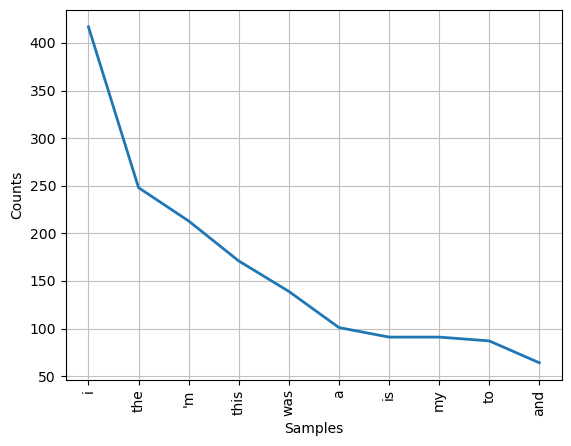

In [286]:
from nltk.probability import FreqDist

# Use FreqDist to calculate the number of each token
# collect all tokens
all_tokens = np.concatenate(data_dict['message'], axis=0)
print(all_tokens)
# number of different tokens
total_token_number = len(set(all_tokens))
print("Number of different tokens:", total_token_number)

fdist = FreqDist(all_tokens)
print("e.g. 'I' : ",fdist['I'])
print("Show top 10 most used words:")
print(fdist.most_common(10))  
fdist.plot(10)

### 3. Generate a word cloud for these texts.

i really enjoyed the movie the food was terrible i 'm not sure how i feel about this the service was excellent i had a bad experience this is a great product i would n't recommend this the price is a bit high the weather is perfect today the traffic is horrible i 'm feeling neutral about this the concert was amazing the customer service was terrible this book is a masterpiece i regret buying this product the view from here is breathtaking i do n't know what to think about this the internet speed is slow the museum was fascinating the noise level is too high i do n't have an opinion on this the hotel room was spacious and clean the service at this restaurant was awful this software is very user-friendly the quality of the product is poor i do n't really care about this the beach was crowded this is an excellent company to work for the movie was a waste of time i 'm undecided about this the game was a complete disaster the scenery here is beautiful the speaker was very engaging i had a g

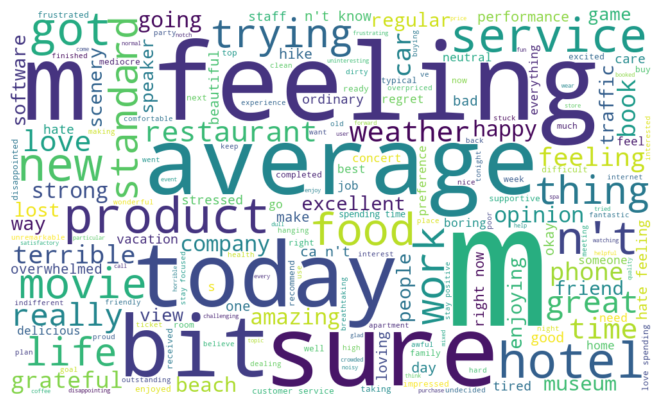

In [287]:
from wordcloud import WordCloud
# Convert list to a single string
text = ' '.join(all_tokens)
print(text)
# Generate word cloud
wordcloud = WordCloud(
    width=1000, height=600,
    background_color='white',
    colormap='viridis',        # or 'Dark2' or 'plasma'
    max_words=200
).generate(text)

# Show the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 4. Develop **two models** to classify these texts into one of the **three** possible sentiments. 
* One of the models should be an RNN.
* Display the confusion matrix for training result of the model.    
* (There is no need to split the provided dataset into training and testing datasets.) 

### 4.1. create word vector by word2vec.

In [288]:
data_dict['message'][:5]

[['i', 'really', 'enjoyed', 'the', 'movie'],
 ['the', 'food', 'was', 'terrible'],
 ['i', "'m", 'not', 'sure', 'how', 'i', 'feel', 'about', 'this'],
 ['the', 'service', 'was', 'excellent'],
 ['i', 'had', 'a', 'bad', 'experience']]

In [289]:
from gensim.models.word2vec import Word2Vec
Hin = 50
# Train the model
model_Word2Vec = Word2Vec(
    sentences=data_dict['message'],  # list of tokenized sentences like [['I', 'love', 'coding'], ['Machine', 'learning', 'is', 'cool']]
    vector_size=Hin,   # size of the embedding vector
    window=5,          # context window size
    min_count=1,       # minimum word frequency to include
    workers=4          # number of threads to use
)
# save the model
model_Word2Vec.save("HW3_2_word2vec.model")
# save the vector
word_vectors = model_Word2Vec.wv
word_vectors.save("HW3_2_word2vec.wordvectors")

* See some vectors

In [290]:
vector = model_Word2Vec.wv['hotel']
print(vector.shape) 
print(vector) 

(50,)
[ 1.0383713e-02  1.3960315e-02  1.8762471e-03 -2.1194406e-02
  7.1063791e-05 -2.1192765e-02  2.8772483e-02  2.8676005e-02
 -1.2461517e-02  6.7320927e-03 -1.7671172e-02 -2.5904564e-02
  1.2292994e-02  1.5712176e-02 -4.3509650e-04  1.4913312e-02
  7.9369992e-03  1.8111269e-03 -1.5096336e-02 -2.3297176e-02
 -9.0450617e-03 -1.1464547e-02  3.2360271e-02 -5.9407954e-03
  5.4798913e-03 -1.8895654e-02  1.5479392e-02  1.0922825e-03
 -1.3319084e-02  8.8094259e-03 -1.9853380e-02  7.2224130e-04
  4.1318596e-03 -1.9046882e-02  8.5050699e-05  7.0674927e-03
  2.8406138e-02  1.3813088e-02  1.2745454e-04 -2.2008035e-02
  2.3503631e-02  3.3563669e-03  9.9068526e-03  1.4592915e-02
  2.5085587e-02 -1.2342671e-02 -8.1716115e-03  9.9376151e-03
 -5.9374622e-03  2.3395315e-02]


In [291]:
vector = model_Word2Vec.wv['🌴']  
print(vector.shape) 
print(vector) 

(50,)
[-0.01280605  0.01713929 -0.01765835 -0.00672814  0.00792713 -0.01092052
 -0.00899633  0.02655797 -0.02673111 -0.01957941  0.0057303  -0.01465897
  0.01885795 -0.01150902 -0.0077108   0.00193715  0.02296886 -0.01046336
 -0.00462247 -0.03430254 -0.01246416  0.00671944  0.01485643 -0.01252977
 -0.00156008  0.00626309 -0.02130787  0.001849   -0.00839251  0.00358412
 -0.00581688  0.0110245  -0.02147808 -0.02024625 -0.00100072  0.01877733
 -0.00289037 -0.01239188  0.00637602 -0.0249005   0.01469302  0.01757006
 -0.01396533 -0.01181961  0.03935657 -0.00061382 -0.01571298 -0.01221141
 -0.0099558  -0.00485699]


In [292]:
# all_vectors = {word: model_Word2Vec.wv[word] for word in model_Word2Vec.wv.index_to_key}

* Find similar words

In [293]:
model_Word2Vec.wv.most_similar('learning', topn=5)

[('..', 0.3899499475955963),
 ('has', 0.3758159577846527),
 ('💦', 0.2926172614097595),
 ('through', 0.27903077006340027),
 ('anything', 0.2762029767036438)]

In [294]:
model_Word2Vec.wv.most_similar('happy', topn=5)

[('a', 0.7442828416824341),
 ('with', 0.7363930344581604),
 ('i', 0.7363638877868652),
 ('so', 0.7274976372718811),
 ('how', 0.7255692481994629)]

In [295]:
model_Word2Vec.wv.similarity('i', 'the')

0.95792496

In [296]:
model_Word2Vec.wv.similarity('excellent', 'good')

0.1649881

* Load back the word2vec model

In [297]:
model_Word2Vec = Word2Vec.load("HW3_2_word2vec.model")

### 4.2. create dataset.

In [298]:
len(data_dict['message'])

584

In [299]:
# Hyper Parameters
LR = 0.001
batch_size_train = 32
NUM_EPOCHS = 150

LABELS = {'negative':0, 'positive':1, 'neutral':2}
max_len = 0
for lst in data_dict['message']:
    if max_len < len(lst):
        max_len = len(lst)
MAX_SEQUENCE_LENGTH = max_len
# if sentences aren't as long as MAX_SEQUENCE_LENGTH, padding it in front of the first word
print(f"MAX_SEQUENCE_LENGTH = {MAX_SEQUENCE_LENGTH}")

# Check available device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Train on {device}.")

MAX_SEQUENCE_LENGTH = 23
Train on cuda.


In [300]:
class TextDataset(Dataset):
    def __init__(self, data_dict, model_Word2Vec, labels):
        self.data_dict = data_dict
        self.model_Word2Vec = model_Word2Vec
        self.num_samples = len(self.data_dict['message'])
        self.labels = labels
        self.zero_vector = np.zeros(self.model_Word2Vec.vector_size)

    def __getitem__(self,idx):
        msg_lst = self.data_dict['message'][idx]
        label = self.labels[self.data_dict['sentiment'][idx]]

        vector = []
        for token in msg_lst:
            if token in self.model_Word2Vec.wv:
                vec = self.model_Word2Vec.wv[token]
            else:
                vec = self.zero_vector  # handle OOV
            vector.append(vec)

        # Pad or truncate to MAX_SEQUENCE_LENGTH
        if len(vector) < MAX_SEQUENCE_LENGTH:
            pad_len = MAX_SEQUENCE_LENGTH - len(vector)
            vector = [[0.0] * Hin] * pad_len + vector  # pad at beginning
        else:
            vector = vector[:MAX_SEQUENCE_LENGTH]  # truncate if too long

        # Convert to tensor
        vector = torch.tensor(np.array(vector), dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)
        return vector, label

    def __len__(self):
        return self.num_samples


In [301]:
train_dataset = TextDataset(data_dict, model_Word2Vec, LABELS)

print("length of train_dataset:", len(train_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True, pin_memory=True)

length of train_dataset: 584


In [302]:
# see if it works
for x, y in train_dataloader:
    print(x.shape, y.shape)
    print(x, y)
    break

torch.Size([32, 23, 50]) torch.Size([32])
tensor([[[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0121, -0.0076, -0.0213,  ...,  0.0153, -0.0013,  0.0146],
         [ 0.0220,  0.0128, -0.0412,  ..., -0.0372,  0.0191,  0.0031],
         [ 0.0031,  0.0110, -0.0009,  ..., -0.0060, -0.0010, -0.0083]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0229,  0.0128, -0.0450,  ..., -0.0336,  0.0558,  0.0078],
         [-0.0003, -0.0026, -0.0237,  ...,  0.0103, -0.0034,  0.0147],
         [-0.0135, -0.0114,  0.0043,  ..., -0.0090,  0.0020,  0.0138]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
   

### 4.3. create **RNN model**.

In [303]:
# define RNN model
class RNN_model_text(nn.Module):
    def __init__(self):
        super(RNN_model_text, self).__init__()
        self.rnn_layers = nn.RNN(Hin, 64, num_layers = 2, batch_first = True) # (input size, output size)
        
        self.classifier_layers = nn.Sequential(
                # Flatten layers
                nn.Linear(64, 3),
            )
        
    def forward(self, x):
        output, _ = self.rnn_layers(x) # output shape is (N, seq_len, Hout)
        # output's shape is (Batch_size, seq_len, Hout)
        
        # Try just see the final time step output
        x = output[:, -1, :]  # get last time step (batch_size, H_out)
        x = self.classifier_layers(x)
        return x

In [304]:
RNN_model = RNN_model_text().to(device)

# pth_path = 'RNN_model_text.pth'
# state_dict = torch.load(pth_path)
# RNN_model.load_state_dict(state_dict)
# print(f"Load pth from {pth_path}")

# set loss function
criterion = nn.CrossEntropyLoss()
# set optimizer
optimizer = torch.optim.Adam(RNN_model.parameters(), lr=LR, betas=(0.9, 0.999))
# Print the model summary
summary(RNN_model, (1, MAX_SEQUENCE_LENGTH, Hin)) # Input size: (Batch_size, height, width), torchinfo.summary need batch size

Layer (type:depth-idx)                   Output Shape              Param #
RNN_model_text                           [1, 3]                    --
├─RNN: 1-1                               [1, 23, 64]               15,744
├─Sequential: 1-2                        [1, 3]                    --
│    └─Linear: 2-1                       [1, 3]                    195
Total params: 15,939
Trainable params: 15,939
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.36
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.06
Estimated Total Size (MB): 0.08

### 4.4. **training**...

In [305]:
from tqdm import tqdm
# train and val func for one epoch
def train_epoch(train_dataloader, model):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        y_pred = model(x)
        # see loss
        loss = criterion(y_pred, y)
        loss.backward()
        
        # update the parameters
        optimizer.step()

        train_loss += loss.item()
        probs = torch.nn.functional.softmax(y_pred, dim=1)
        train_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return train_acc / len(train_dataloader.dataset), train_loss / len(train_dataloader.dataset)

def val_epoch(val_dataloader, model):
    val_loss = 0.0
    val_acc = 0.0
    model.eval()
    with torch.no_grad():
        for x, y in tqdm(val_dataloader):
            x, y = x.to(device), y.to(device)
            # predicting
            y_pred = model(x)
            # see loss
            loss = criterion(y_pred, y)

            val_loss += loss.item()
            probs = torch.nn.functional.softmax(y_pred, dim=1)
            val_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return val_acc / len(val_dataloader.dataset), val_loss / len(val_dataloader.dataset)

def test(test_dataloader, model, type="test"):
    pred_labels = []
    total_probs = []
    true_labels = [] # for testing train dataset
    model.eval()
    with torch.no_grad():
        if type == "test":
            for x, _ in tqdm(test_dataloader):
                x = x.to(device)
                # predicting
                y_pred = model(x)
                probs = torch.nn.functional.softmax(y_pred, dim=1)
                pred_labels.extend(torch.argmax(probs, dim=1).cpu().tolist())
            return pred_labels

        else:
            for x, y in tqdm(test_dataloader):
                x = x.to(device)
                # predicting
                y_pred = model(x)
                probs = torch.nn.functional.softmax(y_pred, dim=1)
                total_probs.append(probs)
                pred_labels.extend(torch.argmax(probs, dim=1).cpu().tolist())
                true_labels.extend(y.cpu().tolist())
            return torch.cat(total_probs, dim=0), pred_labels, true_labels

In [306]:
def plt_loss_accuracy_fig(Total_training_loss, Total_training_accuracy):
    # visualization the loss and accuracy
    plt.figure(figsize=(6,4))
    plt.plot(range(len(Total_training_loss)), Total_training_loss, 'b-', label='Training_loss')
    # Get min loss and epoch
    min_loss = np.min(Total_training_loss)
    min_loss_epoch = Total_training_loss.index(min_loss)

    # Plot the min loss point
    plt.scatter(min_loss_epoch, min_loss, color='red', label=f'Min Loss: {min_loss:.4f} @ Epoch {min_loss_epoch}')
    plt.annotate(f'min_loss:{min_loss:.4f}\nepoch:{min_loss_epoch}', 
                 xy=(min_loss_epoch, min_loss), 
                 xytext=(min_loss_epoch, min_loss + 0.02), 
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=9)
    plt.title('Training loss')
    plt.xlabel('No. of epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(range(len(Total_training_accuracy)), Total_training_accuracy, 'r-', label='Training_accuracy')
    # Get max accuracy and epoch
    max_acc = np.max(Total_training_accuracy)
    max_epoch = Total_training_accuracy.index(max_acc)

    # Plot the max point
    plt.scatter(max_epoch, max_acc, color='blue', label=f'Max Accuracy: {max_acc:.4f} @ Epoch {max_epoch}')
    plt.annotate(f'max_acc:{max_acc:.4f}\nepoch:{max_epoch}', 
                 xy=(max_epoch, max_acc), 
                 xytext=(max_epoch, max_acc + 0.02), 
                 arrowprops=dict(facecolor='black', arrowstyle='->'),
                 fontsize=9)
    
    plt.title('Training accuracy')
    plt.xlabel('No. of epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [307]:
def plot_confusion_matrix(pred_labels, true_labels, num_classes=len(LABELS)):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, pred_labels, labels=np.arange(num_classes))

    # Plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(7, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=np.arange(num_classes), yticklabels=np.arange(num_classes))

    # Add labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [308]:
# Start training and testing
max_accuracy = 0
# For ploting the trend image
total_train_acc = []
total_train_loss = []
for i in range(NUM_EPOCHS):
    train_acc, train_loss = train_epoch(train_dataloader, RNN_model)
    # record the training data
    total_train_acc.append(train_acc)

    total_train_loss.append(train_loss)

    print("Epoch[{:>2d}/{:>2d}] : train_acc = {:.4f}, train_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_acc, train_loss))
    # update model pth when larger val_acc happens
    if(train_acc > max_accuracy):
        max_accuracy = train_acc
        save_parameters = True
        if save_parameters:
            path = 'RNN_model_text.pth'
            torch.save(RNN_model.state_dict(), path)
            print("\t\33[33m====Save model parameters in {:s} when val_acc is {:.4f}====\33[0m".format(path, train_acc))

# save the final epoch's model
path = 'RNN_model_text_final_epoch.pth'
torch.save(RNN_model.state_dict(), path)
print("\t\33[33m====Save FINAL model parameters in {:s}====\33[0m".format(path))

100%|██████████| 19/19 [00:00<00:00, 189.99it/s]


Epoch[ 1/150] : train_acc = 0.4247, train_loss = 0.0351
	====Save model parameters in RNN_model_text.pth when val_acc is 0.4247====


100%|██████████| 19/19 [00:00<00:00, 191.64it/s]


Epoch[ 2/150] : train_acc = 0.4435, train_loss = 0.0349
	====Save model parameters in RNN_model_text.pth when val_acc is 0.4435====


100%|██████████| 19/19 [00:00<00:00, 206.46it/s]


Epoch[ 3/150] : train_acc = 0.4435, train_loss = 0.0347


100%|██████████| 19/19 [00:00<00:00, 205.18it/s]


Epoch[ 4/150] : train_acc = 0.4435, train_loss = 0.0346


100%|██████████| 19/19 [00:00<00:00, 206.01it/s]


Epoch[ 5/150] : train_acc = 0.4452, train_loss = 0.0345
	====Save model parameters in RNN_model_text.pth when val_acc is 0.4452====


100%|██████████| 19/19 [00:00<00:00, 198.15it/s]


Epoch[ 6/150] : train_acc = 0.4452, train_loss = 0.0344


100%|██████████| 19/19 [00:00<00:00, 214.87it/s]


Epoch[ 7/150] : train_acc = 0.4401, train_loss = 0.0343


100%|██████████| 19/19 [00:00<00:00, 220.51it/s]


Epoch[ 8/150] : train_acc = 0.4486, train_loss = 0.0337
	====Save model parameters in RNN_model_text.pth when val_acc is 0.4486====


100%|██████████| 19/19 [00:00<00:00, 201.08it/s]


Epoch[ 9/150] : train_acc = 0.4572, train_loss = 0.0332
	====Save model parameters in RNN_model_text.pth when val_acc is 0.4572====


100%|██████████| 19/19 [00:00<00:00, 208.45it/s]


Epoch[10/150] : train_acc = 0.4623, train_loss = 0.0331
	====Save model parameters in RNN_model_text.pth when val_acc is 0.4623====


100%|██████████| 19/19 [00:00<00:00, 195.67it/s]


Epoch[11/150] : train_acc = 0.5086, train_loss = 0.0322
	====Save model parameters in RNN_model_text.pth when val_acc is 0.5086====


100%|██████████| 19/19 [00:00<00:00, 196.28it/s]


Epoch[12/150] : train_acc = 0.5137, train_loss = 0.0315
	====Save model parameters in RNN_model_text.pth when val_acc is 0.5137====


100%|██████████| 19/19 [00:00<00:00, 207.32it/s]


Epoch[13/150] : train_acc = 0.5188, train_loss = 0.0308
	====Save model parameters in RNN_model_text.pth when val_acc is 0.5188====


100%|██████████| 19/19 [00:00<00:00, 211.63it/s]


Epoch[14/150] : train_acc = 0.5325, train_loss = 0.0303
	====Save model parameters in RNN_model_text.pth when val_acc is 0.5325====


100%|██████████| 19/19 [00:00<00:00, 192.61it/s]


Epoch[15/150] : train_acc = 0.5342, train_loss = 0.0306
	====Save model parameters in RNN_model_text.pth when val_acc is 0.5342====


100%|██████████| 19/19 [00:00<00:00, 218.21it/s]


Epoch[16/150] : train_acc = 0.5788, train_loss = 0.0291
	====Save model parameters in RNN_model_text.pth when val_acc is 0.5788====


100%|██████████| 19/19 [00:00<00:00, 200.12it/s]


Epoch[17/150] : train_acc = 0.5890, train_loss = 0.0282
	====Save model parameters in RNN_model_text.pth when val_acc is 0.5890====


100%|██████████| 19/19 [00:00<00:00, 209.54it/s]


Epoch[18/150] : train_acc = 0.5908, train_loss = 0.0278
	====Save model parameters in RNN_model_text.pth when val_acc is 0.5908====


100%|██████████| 19/19 [00:00<00:00, 218.47it/s]


Epoch[19/150] : train_acc = 0.5822, train_loss = 0.0281


100%|██████████| 19/19 [00:00<00:00, 207.40it/s]


Epoch[20/150] : train_acc = 0.6147, train_loss = 0.0273
	====Save model parameters in RNN_model_text.pth when val_acc is 0.6147====


100%|██████████| 19/19 [00:00<00:00, 204.26it/s]


Epoch[21/150] : train_acc = 0.6318, train_loss = 0.0261
	====Save model parameters in RNN_model_text.pth when val_acc is 0.6318====


100%|██████████| 19/19 [00:00<00:00, 207.01it/s]


Epoch[22/150] : train_acc = 0.6027, train_loss = 0.0269


100%|██████████| 19/19 [00:00<00:00, 222.80it/s]


Epoch[23/150] : train_acc = 0.6524, train_loss = 0.0242
	====Save model parameters in RNN_model_text.pth when val_acc is 0.6524====


100%|██████████| 19/19 [00:00<00:00, 198.28it/s]


Epoch[24/150] : train_acc = 0.6678, train_loss = 0.0248
	====Save model parameters in RNN_model_text.pth when val_acc is 0.6678====


100%|██████████| 19/19 [00:00<00:00, 201.88it/s]


Epoch[25/150] : train_acc = 0.6387, train_loss = 0.0244


100%|██████████| 19/19 [00:00<00:00, 192.52it/s]


Epoch[26/150] : train_acc = 0.6490, train_loss = 0.0244


100%|██████████| 19/19 [00:00<00:00, 200.01it/s]


Epoch[27/150] : train_acc = 0.6764, train_loss = 0.0235
	====Save model parameters in RNN_model_text.pth when val_acc is 0.6764====


100%|██████████| 19/19 [00:00<00:00, 206.18it/s]


Epoch[28/150] : train_acc = 0.6935, train_loss = 0.0231
	====Save model parameters in RNN_model_text.pth when val_acc is 0.6935====


100%|██████████| 19/19 [00:00<00:00, 234.23it/s]


Epoch[29/150] : train_acc = 0.6884, train_loss = 0.0235


100%|██████████| 19/19 [00:00<00:00, 201.87it/s]


Epoch[30/150] : train_acc = 0.6781, train_loss = 0.0228


100%|██████████| 19/19 [00:00<00:00, 208.12it/s]


Epoch[31/150] : train_acc = 0.7260, train_loss = 0.0213
	====Save model parameters in RNN_model_text.pth when val_acc is 0.7260====


100%|██████████| 19/19 [00:00<00:00, 196.39it/s]


Epoch[32/150] : train_acc = 0.7158, train_loss = 0.0205


100%|██████████| 19/19 [00:00<00:00, 212.50it/s]


Epoch[33/150] : train_acc = 0.7363, train_loss = 0.0198
	====Save model parameters in RNN_model_text.pth when val_acc is 0.7363====


100%|██████████| 19/19 [00:00<00:00, 212.66it/s]


Epoch[34/150] : train_acc = 0.7209, train_loss = 0.0205


100%|██████████| 19/19 [00:00<00:00, 212.34it/s]


Epoch[35/150] : train_acc = 0.7295, train_loss = 0.0203


100%|██████████| 19/19 [00:00<00:00, 200.89it/s]


Epoch[36/150] : train_acc = 0.7295, train_loss = 0.0200


100%|██████████| 19/19 [00:00<00:00, 221.71it/s]


Epoch[37/150] : train_acc = 0.7620, train_loss = 0.0190
	====Save model parameters in RNN_model_text.pth when val_acc is 0.7620====


100%|██████████| 19/19 [00:00<00:00, 213.00it/s]


Epoch[38/150] : train_acc = 0.7637, train_loss = 0.0186
	====Save model parameters in RNN_model_text.pth when val_acc is 0.7637====


100%|██████████| 19/19 [00:00<00:00, 199.72it/s]


Epoch[39/150] : train_acc = 0.7620, train_loss = 0.0194


100%|██████████| 19/19 [00:00<00:00, 221.43it/s]


Epoch[40/150] : train_acc = 0.7705, train_loss = 0.0181
	====Save model parameters in RNN_model_text.pth when val_acc is 0.7705====


100%|██████████| 19/19 [00:00<00:00, 214.50it/s]


Epoch[41/150] : train_acc = 0.7637, train_loss = 0.0179


100%|██████████| 19/19 [00:00<00:00, 186.14it/s]


Epoch[42/150] : train_acc = 0.7723, train_loss = 0.0169
	====Save model parameters in RNN_model_text.pth when val_acc is 0.7723====


100%|██████████| 19/19 [00:00<00:00, 210.51it/s]


Epoch[43/150] : train_acc = 0.7911, train_loss = 0.0162
	====Save model parameters in RNN_model_text.pth when val_acc is 0.7911====


100%|██████████| 19/19 [00:00<00:00, 216.47it/s]


Epoch[44/150] : train_acc = 0.7774, train_loss = 0.0166


100%|██████████| 19/19 [00:00<00:00, 208.23it/s]


Epoch[45/150] : train_acc = 0.7911, train_loss = 0.0157


100%|██████████| 19/19 [00:00<00:00, 208.85it/s]


Epoch[46/150] : train_acc = 0.7894, train_loss = 0.0159


100%|██████████| 19/19 [00:00<00:00, 193.49it/s]


Epoch[47/150] : train_acc = 0.8151, train_loss = 0.0153
	====Save model parameters in RNN_model_text.pth when val_acc is 0.8151====


100%|██████████| 19/19 [00:00<00:00, 192.06it/s]


Epoch[48/150] : train_acc = 0.8202, train_loss = 0.0143
	====Save model parameters in RNN_model_text.pth when val_acc is 0.8202====


100%|██████████| 19/19 [00:00<00:00, 213.90it/s]


Epoch[49/150] : train_acc = 0.8373, train_loss = 0.0141
	====Save model parameters in RNN_model_text.pth when val_acc is 0.8373====


100%|██████████| 19/19 [00:00<00:00, 223.14it/s]


Epoch[50/150] : train_acc = 0.8185, train_loss = 0.0142


100%|██████████| 19/19 [00:00<00:00, 197.94it/s]


Epoch[51/150] : train_acc = 0.8339, train_loss = 0.0142


100%|██████████| 19/19 [00:00<00:00, 210.66it/s]


Epoch[52/150] : train_acc = 0.8202, train_loss = 0.0150


100%|██████████| 19/19 [00:00<00:00, 210.18it/s]


Epoch[53/150] : train_acc = 0.7911, train_loss = 0.0156


100%|██████████| 19/19 [00:00<00:00, 209.77it/s]


Epoch[54/150] : train_acc = 0.8134, train_loss = 0.0142


100%|██████████| 19/19 [00:00<00:00, 236.70it/s]


Epoch[55/150] : train_acc = 0.8339, train_loss = 0.0136


100%|██████████| 19/19 [00:00<00:00, 220.16it/s]


Epoch[56/150] : train_acc = 0.8493, train_loss = 0.0125
	====Save model parameters in RNN_model_text.pth when val_acc is 0.8493====


100%|██████████| 19/19 [00:00<00:00, 220.87it/s]


Epoch[57/150] : train_acc = 0.8510, train_loss = 0.0132
	====Save model parameters in RNN_model_text.pth when val_acc is 0.8510====


100%|██████████| 19/19 [00:00<00:00, 198.67it/s]


Epoch[58/150] : train_acc = 0.8613, train_loss = 0.0122
	====Save model parameters in RNN_model_text.pth when val_acc is 0.8613====


100%|██████████| 19/19 [00:00<00:00, 210.11it/s]


Epoch[59/150] : train_acc = 0.8699, train_loss = 0.0116
	====Save model parameters in RNN_model_text.pth when val_acc is 0.8699====


100%|██████████| 19/19 [00:00<00:00, 220.49it/s]


Epoch[60/150] : train_acc = 0.8767, train_loss = 0.0109
	====Save model parameters in RNN_model_text.pth when val_acc is 0.8767====


100%|██████████| 19/19 [00:00<00:00, 211.03it/s]


Epoch[61/150] : train_acc = 0.8784, train_loss = 0.0108
	====Save model parameters in RNN_model_text.pth when val_acc is 0.8784====


100%|██████████| 19/19 [00:00<00:00, 221.42it/s]


Epoch[62/150] : train_acc = 0.8887, train_loss = 0.0102
	====Save model parameters in RNN_model_text.pth when val_acc is 0.8887====


100%|██████████| 19/19 [00:00<00:00, 212.39it/s]


Epoch[63/150] : train_acc = 0.8630, train_loss = 0.0107


100%|██████████| 19/19 [00:00<00:00, 205.22it/s]


Epoch[64/150] : train_acc = 0.8767, train_loss = 0.0109


100%|██████████| 19/19 [00:00<00:00, 203.49it/s]


Epoch[65/150] : train_acc = 0.8579, train_loss = 0.0118


100%|██████████| 19/19 [00:00<00:00, 213.05it/s]


Epoch[66/150] : train_acc = 0.8596, train_loss = 0.0122


100%|██████████| 19/19 [00:00<00:00, 205.24it/s]


Epoch[67/150] : train_acc = 0.8562, train_loss = 0.0116


100%|██████████| 19/19 [00:00<00:00, 206.59it/s]


Epoch[68/150] : train_acc = 0.8853, train_loss = 0.0105


100%|██████████| 19/19 [00:00<00:00, 223.25it/s]


Epoch[69/150] : train_acc = 0.8836, train_loss = 0.0101


100%|██████████| 19/19 [00:00<00:00, 209.34it/s]


Epoch[70/150] : train_acc = 0.8904, train_loss = 0.0098
	====Save model parameters in RNN_model_text.pth when val_acc is 0.8904====


100%|██████████| 19/19 [00:00<00:00, 212.35it/s]


Epoch[71/150] : train_acc = 0.8921, train_loss = 0.0097
	====Save model parameters in RNN_model_text.pth when val_acc is 0.8921====


100%|██████████| 19/19 [00:00<00:00, 223.49it/s]


Epoch[72/150] : train_acc = 0.9007, train_loss = 0.0104
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9007====


100%|██████████| 19/19 [00:00<00:00, 199.64it/s]


Epoch[73/150] : train_acc = 0.8682, train_loss = 0.0107


100%|██████████| 19/19 [00:00<00:00, 219.28it/s]


Epoch[74/150] : train_acc = 0.9024, train_loss = 0.0098
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9024====


100%|██████████| 19/19 [00:00<00:00, 221.54it/s]


Epoch[75/150] : train_acc = 0.8870, train_loss = 0.0097


100%|██████████| 19/19 [00:00<00:00, 214.55it/s]


Epoch[76/150] : train_acc = 0.8870, train_loss = 0.0099


100%|██████████| 19/19 [00:00<00:00, 227.87it/s]


Epoch[77/150] : train_acc = 0.8973, train_loss = 0.0091


100%|██████████| 19/19 [00:00<00:00, 213.18it/s]


Epoch[78/150] : train_acc = 0.9127, train_loss = 0.0082
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9127====


100%|██████████| 19/19 [00:00<00:00, 202.99it/s]


Epoch[79/150] : train_acc = 0.9195, train_loss = 0.0083
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9195====


100%|██████████| 19/19 [00:00<00:00, 206.97it/s]


Epoch[80/150] : train_acc = 0.9041, train_loss = 0.0084


100%|██████████| 19/19 [00:00<00:00, 218.41it/s]


Epoch[81/150] : train_acc = 0.8990, train_loss = 0.0082


100%|██████████| 19/19 [00:00<00:00, 220.34it/s]


Epoch[82/150] : train_acc = 0.9178, train_loss = 0.0075


100%|██████████| 19/19 [00:00<00:00, 215.40it/s]


Epoch[83/150] : train_acc = 0.9161, train_loss = 0.0079


100%|██████████| 19/19 [00:00<00:00, 222.87it/s]


Epoch[84/150] : train_acc = 0.9212, train_loss = 0.0072
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9212====


100%|██████████| 19/19 [00:00<00:00, 221.78it/s]


Epoch[85/150] : train_acc = 0.9144, train_loss = 0.0073


100%|██████████| 19/19 [00:00<00:00, 231.70it/s]


Epoch[86/150] : train_acc = 0.9281, train_loss = 0.0066
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9281====


100%|██████████| 19/19 [00:00<00:00, 227.93it/s]


Epoch[87/150] : train_acc = 0.9264, train_loss = 0.0069


100%|██████████| 19/19 [00:00<00:00, 210.56it/s]


Epoch[88/150] : train_acc = 0.9315, train_loss = 0.0063
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9315====


100%|██████████| 19/19 [00:00<00:00, 208.32it/s]


Epoch[89/150] : train_acc = 0.9298, train_loss = 0.0066


100%|██████████| 19/19 [00:00<00:00, 184.99it/s]


Epoch[90/150] : train_acc = 0.9264, train_loss = 0.0064


100%|██████████| 19/19 [00:00<00:00, 190.20it/s]


Epoch[91/150] : train_acc = 0.9212, train_loss = 0.0069


100%|██████████| 19/19 [00:00<00:00, 213.39it/s]


Epoch[92/150] : train_acc = 0.9229, train_loss = 0.0062


100%|██████████| 19/19 [00:00<00:00, 212.17it/s]


Epoch[93/150] : train_acc = 0.9418, train_loss = 0.0061
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9418====


100%|██████████| 19/19 [00:00<00:00, 220.99it/s]


Epoch[94/150] : train_acc = 0.9435, train_loss = 0.0058
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9435====


100%|██████████| 19/19 [00:00<00:00, 212.90it/s]


Epoch[95/150] : train_acc = 0.9366, train_loss = 0.0054


100%|██████████| 19/19 [00:00<00:00, 214.22it/s]


Epoch[96/150] : train_acc = 0.9452, train_loss = 0.0054
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9452====


100%|██████████| 19/19 [00:00<00:00, 199.27it/s]


Epoch[97/150] : train_acc = 0.9452, train_loss = 0.0054


100%|██████████| 19/19 [00:00<00:00, 225.55it/s]


Epoch[98/150] : train_acc = 0.9469, train_loss = 0.0054
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9469====


100%|██████████| 19/19 [00:00<00:00, 228.24it/s]


Epoch[99/150] : train_acc = 0.9247, train_loss = 0.0065


100%|██████████| 19/19 [00:00<00:00, 213.31it/s]


Epoch[100/150] : train_acc = 0.9315, train_loss = 0.0060


100%|██████████| 19/19 [00:00<00:00, 196.63it/s]


Epoch[101/150] : train_acc = 0.9418, train_loss = 0.0061


100%|██████████| 19/19 [00:00<00:00, 229.34it/s]


Epoch[102/150] : train_acc = 0.9349, train_loss = 0.0058


100%|██████████| 19/19 [00:00<00:00, 199.69it/s]


Epoch[103/150] : train_acc = 0.9418, train_loss = 0.0066


100%|██████████| 19/19 [00:00<00:00, 227.46it/s]


Epoch[104/150] : train_acc = 0.9349, train_loss = 0.0055


100%|██████████| 19/19 [00:00<00:00, 219.92it/s]


Epoch[105/150] : train_acc = 0.9521, train_loss = 0.0051
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9521====


100%|██████████| 19/19 [00:00<00:00, 221.61it/s]


Epoch[106/150] : train_acc = 0.9469, train_loss = 0.0060


100%|██████████| 19/19 [00:00<00:00, 234.42it/s]


Epoch[107/150] : train_acc = 0.9384, train_loss = 0.0056


100%|██████████| 19/19 [00:00<00:00, 196.51it/s]


Epoch[108/150] : train_acc = 0.9486, train_loss = 0.0047


100%|██████████| 19/19 [00:00<00:00, 218.19it/s]


Epoch[109/150] : train_acc = 0.9435, train_loss = 0.0052


100%|██████████| 19/19 [00:00<00:00, 216.55it/s]


Epoch[110/150] : train_acc = 0.9521, train_loss = 0.0045


100%|██████████| 19/19 [00:00<00:00, 217.93it/s]


Epoch[111/150] : train_acc = 0.9538, train_loss = 0.0047
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9538====


100%|██████████| 19/19 [00:00<00:00, 217.10it/s]


Epoch[112/150] : train_acc = 0.9349, train_loss = 0.0060


100%|██████████| 19/19 [00:00<00:00, 213.53it/s]


Epoch[113/150] : train_acc = 0.9281, train_loss = 0.0072


100%|██████████| 19/19 [00:00<00:00, 201.05it/s]


Epoch[114/150] : train_acc = 0.9247, train_loss = 0.0065


100%|██████████| 19/19 [00:00<00:00, 213.41it/s]


Epoch[115/150] : train_acc = 0.9281, train_loss = 0.0063


100%|██████████| 19/19 [00:00<00:00, 217.86it/s]


Epoch[116/150] : train_acc = 0.9469, train_loss = 0.0048


100%|██████████| 19/19 [00:00<00:00, 196.38it/s]


Epoch[117/150] : train_acc = 0.9521, train_loss = 0.0063


100%|██████████| 19/19 [00:00<00:00, 241.54it/s]


Epoch[118/150] : train_acc = 0.9435, train_loss = 0.0052


100%|██████████| 19/19 [00:00<00:00, 231.46it/s]


Epoch[119/150] : train_acc = 0.9452, train_loss = 0.0052


100%|██████████| 19/19 [00:00<00:00, 209.49it/s]


Epoch[120/150] : train_acc = 0.9229, train_loss = 0.0064


100%|██████████| 19/19 [00:00<00:00, 212.73it/s]


Epoch[121/150] : train_acc = 0.9469, train_loss = 0.0052


100%|██████████| 19/19 [00:00<00:00, 211.47it/s]


Epoch[122/150] : train_acc = 0.9452, train_loss = 0.0049


100%|██████████| 19/19 [00:00<00:00, 203.79it/s]


Epoch[123/150] : train_acc = 0.9486, train_loss = 0.0058


100%|██████████| 19/19 [00:00<00:00, 180.04it/s]


Epoch[124/150] : train_acc = 0.9212, train_loss = 0.0074


100%|██████████| 19/19 [00:00<00:00, 168.10it/s]


Epoch[125/150] : train_acc = 0.9161, train_loss = 0.0075


100%|██████████| 19/19 [00:00<00:00, 231.14it/s]


Epoch[126/150] : train_acc = 0.9418, train_loss = 0.0054


100%|██████████| 19/19 [00:00<00:00, 244.09it/s]


Epoch[127/150] : train_acc = 0.9469, train_loss = 0.0049


100%|██████████| 19/19 [00:00<00:00, 247.06it/s]


Epoch[128/150] : train_acc = 0.9452, train_loss = 0.0045


100%|██████████| 19/19 [00:00<00:00, 230.84it/s]


Epoch[129/150] : train_acc = 0.9640, train_loss = 0.0043
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9640====


100%|██████████| 19/19 [00:00<00:00, 242.81it/s]


Epoch[130/150] : train_acc = 0.9555, train_loss = 0.0044


100%|██████████| 19/19 [00:00<00:00, 230.97it/s]


Epoch[131/150] : train_acc = 0.9538, train_loss = 0.0050


100%|██████████| 19/19 [00:00<00:00, 234.30it/s]


Epoch[132/150] : train_acc = 0.9606, train_loss = 0.0039


100%|██████████| 19/19 [00:00<00:00, 236.07it/s]


Epoch[133/150] : train_acc = 0.9623, train_loss = 0.0042


100%|██████████| 19/19 [00:00<00:00, 254.21it/s]


Epoch[134/150] : train_acc = 0.9606, train_loss = 0.0042


100%|██████████| 19/19 [00:00<00:00, 250.32it/s]


Epoch[135/150] : train_acc = 0.9640, train_loss = 0.0036


100%|██████████| 19/19 [00:00<00:00, 260.30it/s]


Epoch[136/150] : train_acc = 0.9623, train_loss = 0.0037


100%|██████████| 19/19 [00:00<00:00, 233.22it/s]


Epoch[137/150] : train_acc = 0.9572, train_loss = 0.0040


100%|██████████| 19/19 [00:00<00:00, 248.81it/s]


Epoch[138/150] : train_acc = 0.9589, train_loss = 0.0042


100%|██████████| 19/19 [00:00<00:00, 237.92it/s]


Epoch[139/150] : train_acc = 0.9658, train_loss = 0.0037
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9658====


100%|██████████| 19/19 [00:00<00:00, 228.24it/s]


Epoch[140/150] : train_acc = 0.9692, train_loss = 0.0038
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9692====


100%|██████████| 19/19 [00:00<00:00, 235.66it/s]


Epoch[141/150] : train_acc = 0.9640, train_loss = 0.0035


100%|██████████| 19/19 [00:00<00:00, 266.29it/s]


Epoch[142/150] : train_acc = 0.9743, train_loss = 0.0033
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9743====


100%|██████████| 19/19 [00:00<00:00, 243.17it/s]


Epoch[143/150] : train_acc = 0.9709, train_loss = 0.0033


100%|██████████| 19/19 [00:00<00:00, 236.34it/s]


Epoch[144/150] : train_acc = 0.9760, train_loss = 0.0031
	====Save model parameters in RNN_model_text.pth when val_acc is 0.9760====


100%|██████████| 19/19 [00:00<00:00, 233.95it/s]


Epoch[145/150] : train_acc = 0.9743, train_loss = 0.0030


100%|██████████| 19/19 [00:00<00:00, 230.59it/s]


Epoch[146/150] : train_acc = 0.9709, train_loss = 0.0030


100%|██████████| 19/19 [00:00<00:00, 249.05it/s]


Epoch[147/150] : train_acc = 0.9743, train_loss = 0.0027


100%|██████████| 19/19 [00:00<00:00, 230.41it/s]


Epoch[148/150] : train_acc = 0.9709, train_loss = 0.0031


100%|██████████| 19/19 [00:00<00:00, 212.80it/s]


Epoch[149/150] : train_acc = 0.9640, train_loss = 0.0034


100%|██████████| 19/19 [00:00<00:00, 229.62it/s]

Epoch[150/150] : train_acc = 0.9606, train_loss = 0.0036
	====Save FINAL model parameters in RNN_model_text_final_epoch.pth====


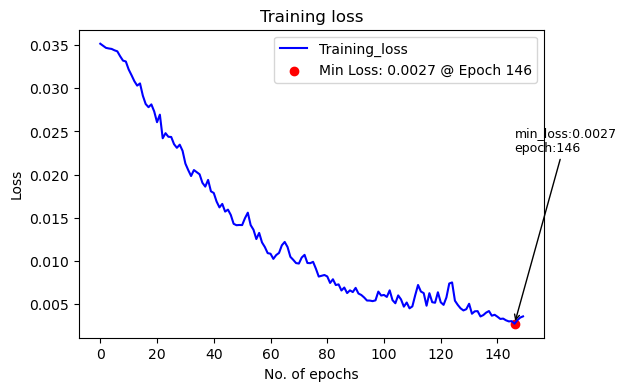

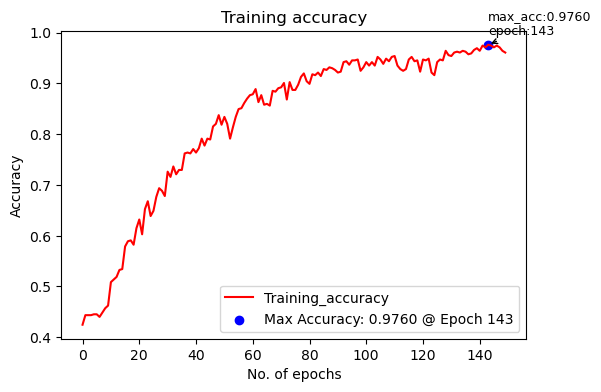

In [309]:
plt_loss_accuracy_fig(total_train_loss, total_train_acc)

Load pth from RNN_model_text.pth


100%|██████████| 19/19 [00:00<00:00, 417.73it/s]

Top-1 Accuracy: 0.9640


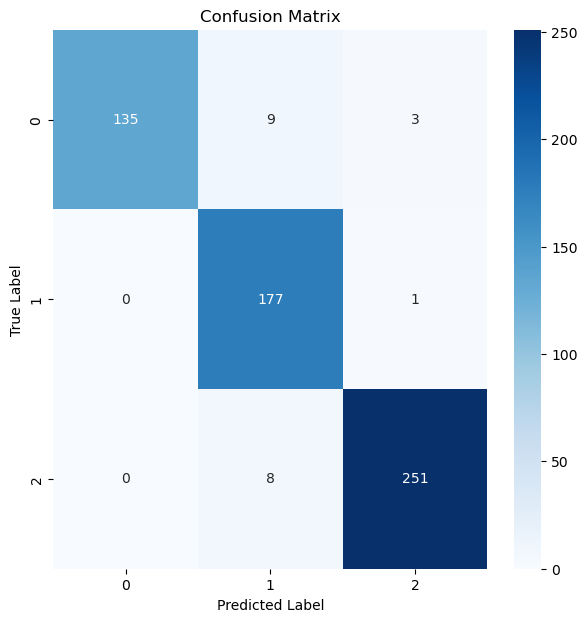

In [310]:
# Load back the model
RNN_model = RNN_model_text().to(device)

pth_path = 'RNN_model_text.pth'
state_dict = torch.load(pth_path)
RNN_model.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")

total_train_probs, train_pred_labels, true_labels = test(train_dataloader, RNN_model, type="train")

top_1_acc = 0.0
num_samples = len(true_labels)

for probs, label in zip(total_train_probs, true_labels):
    # Get top 3 predictions
    top3_probs, top3_indices = torch.topk(probs, 3, dim=0, largest=True, sorted=True)

    # Top-1 accuracy: if the top-1 predicted class matches the true label
    if top3_indices[0] == label:
        top_1_acc += 1


# Calculate the final accuracy
top_1_acc /= num_samples

print(f"Top-1 Accuracy: {top_1_acc:.4f}")
plot_confusion_matrix(train_pred_labels, true_labels)

### 4.5. create GRU model.

In [311]:
# define RNN model
class GRU_model_text(nn.Module):
    def __init__(self):
        super(GRU_model_text, self).__init__()
        self.gru_layers = nn.GRU(Hin, 128, num_layers = 2, batch_first = True) # (input size, output size)
        
        self.classifier_layers = nn.Sequential(
                # Flatten layers
                nn.Linear(128, 3)
            )
        
    def forward(self, x):
        output, hn = self.gru_layers(x) # output shape is (N,L,D∗Hout) 

        # Try just see the final time step output
        x = output[:, -1, :]  # get last time step (batch_size, H_out)
        # print("CCC", x.shape) 
        x = self.classifier_layers(x)
        return x

In [312]:
GRU_model = GRU_model_text().to(device)

# pth_path = 'GRU_model_text.pth'
# state_dict = torch.load(pth_path)
# GRU_model.load_state_dict(state_dict)
# print(f"Load pth from {pth_path}")

# set loss function
criterion = nn.CrossEntropyLoss()
# set optimizer
optimizer = torch.optim.Adam(GRU_model.parameters(), lr=LR)
# Print the model summary
summary(GRU_model, (1, MAX_SEQUENCE_LENGTH, Hin)) # Input size: (height, width)

Layer (type:depth-idx)                   Output Shape              Param #
GRU_model_text                           [1, 3]                    --
├─GRU: 1-1                               [1, 23, 128]              168,192
├─Sequential: 1-2                        [1, 3]                    --
│    └─Linear: 2-1                       [1, 3]                    387
Total params: 168,579
Trainable params: 168,579
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 3.87
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.67
Estimated Total Size (MB): 0.70

### 4.6. training second model...

In [313]:
# Start training and testing
max_accuracy = 0
# For ploting the trend image
total_train_acc = []
total_train_loss = []
for i in range(NUM_EPOCHS):
    train_acc, train_loss = train_epoch(train_dataloader, GRU_model)
    # record the training data
    total_train_acc.append(train_acc)

    total_train_loss.append(train_loss)

    print("Epoch[{:>2d}/{:>2d}] : train_acc = {:.4f}, train_loss = {:.4f}".format(i+1, NUM_EPOCHS, train_acc, train_loss))
    # update model pth when larger val_acc happens
    if(train_acc > max_accuracy):
        max_accuracy = train_acc
        save_parameters = True
        if save_parameters:
            path = 'GRU_model_text.pth'
            torch.save(GRU_model.state_dict(), path)
            print("\t\33[33m====Save model parameters in {:s} when val_acc is {:.4f}====\33[0m".format(path, train_acc))

# save the final epoch's model
path = 'GRU_model_text_final_epoch.pth'
torch.save(GRU_model.state_dict(), path)
print("\t\33[33m====Save FINAL model parameters in {:s}====\33[0m".format(path))

100%|██████████| 19/19 [00:00<00:00, 203.53it/s]


Epoch[ 1/150] : train_acc = 0.4435, train_loss = 0.0350
	====Save model parameters in GRU_model_text.pth when val_acc is 0.4435====


100%|██████████| 19/19 [00:00<00:00, 206.22it/s]


Epoch[ 2/150] : train_acc = 0.4435, train_loss = 0.0348


100%|██████████| 19/19 [00:00<00:00, 195.11it/s]


Epoch[ 3/150] : train_acc = 0.4435, train_loss = 0.0348


100%|██████████| 19/19 [00:00<00:00, 208.82it/s]


Epoch[ 4/150] : train_acc = 0.4435, train_loss = 0.0350


100%|██████████| 19/19 [00:00<00:00, 204.94it/s]


Epoch[ 5/150] : train_acc = 0.4435, train_loss = 0.0349


100%|██████████| 19/19 [00:00<00:00, 173.96it/s]


Epoch[ 6/150] : train_acc = 0.4435, train_loss = 0.0348


100%|██████████| 19/19 [00:00<00:00, 184.97it/s]


Epoch[ 7/150] : train_acc = 0.4435, train_loss = 0.0346


100%|██████████| 19/19 [00:00<00:00, 209.24it/s]


Epoch[ 8/150] : train_acc = 0.4435, train_loss = 0.0342


100%|██████████| 19/19 [00:00<00:00, 212.90it/s]


Epoch[ 9/150] : train_acc = 0.4503, train_loss = 0.0330
	====Save model parameters in GRU_model_text.pth when val_acc is 0.4503====


100%|██████████| 19/19 [00:00<00:00, 192.02it/s]


Epoch[10/150] : train_acc = 0.4777, train_loss = 0.0328
	====Save model parameters in GRU_model_text.pth when val_acc is 0.4777====


100%|██████████| 19/19 [00:00<00:00, 197.58it/s]


Epoch[11/150] : train_acc = 0.4949, train_loss = 0.0309
	====Save model parameters in GRU_model_text.pth when val_acc is 0.4949====


100%|██████████| 19/19 [00:00<00:00, 229.15it/s]


Epoch[12/150] : train_acc = 0.5137, train_loss = 0.0312
	====Save model parameters in GRU_model_text.pth when val_acc is 0.5137====


100%|██████████| 19/19 [00:00<00:00, 231.69it/s]


Epoch[13/150] : train_acc = 0.5394, train_loss = 0.0294
	====Save model parameters in GRU_model_text.pth when val_acc is 0.5394====


100%|██████████| 19/19 [00:00<00:00, 224.68it/s]


Epoch[14/150] : train_acc = 0.5599, train_loss = 0.0289
	====Save model parameters in GRU_model_text.pth when val_acc is 0.5599====


100%|██████████| 19/19 [00:00<00:00, 198.48it/s]


Epoch[15/150] : train_acc = 0.5890, train_loss = 0.0284
	====Save model parameters in GRU_model_text.pth when val_acc is 0.5890====


100%|██████████| 19/19 [00:00<00:00, 212.42it/s]


Epoch[16/150] : train_acc = 0.6182, train_loss = 0.0283
	====Save model parameters in GRU_model_text.pth when val_acc is 0.6182====


100%|██████████| 19/19 [00:00<00:00, 234.39it/s]


Epoch[17/150] : train_acc = 0.6130, train_loss = 0.0270


100%|██████████| 19/19 [00:00<00:00, 212.90it/s]


Epoch[18/150] : train_acc = 0.6045, train_loss = 0.0272


100%|██████████| 19/19 [00:00<00:00, 214.07it/s]


Epoch[19/150] : train_acc = 0.6233, train_loss = 0.0272
	====Save model parameters in GRU_model_text.pth when val_acc is 0.6233====


100%|██████████| 19/19 [00:00<00:00, 191.43it/s]


Epoch[20/150] : train_acc = 0.6387, train_loss = 0.0270
	====Save model parameters in GRU_model_text.pth when val_acc is 0.6387====


100%|██████████| 19/19 [00:00<00:00, 217.18it/s]


Epoch[21/150] : train_acc = 0.6455, train_loss = 0.0258
	====Save model parameters in GRU_model_text.pth when val_acc is 0.6455====


100%|██████████| 19/19 [00:00<00:00, 227.86it/s]


Epoch[22/150] : train_acc = 0.6473, train_loss = 0.0255
	====Save model parameters in GRU_model_text.pth when val_acc is 0.6473====


100%|██████████| 19/19 [00:00<00:00, 199.87it/s]


Epoch[23/150] : train_acc = 0.6370, train_loss = 0.0257


100%|██████████| 19/19 [00:00<00:00, 211.70it/s]


Epoch[24/150] : train_acc = 0.6627, train_loss = 0.0246
	====Save model parameters in GRU_model_text.pth when val_acc is 0.6627====


100%|██████████| 19/19 [00:00<00:00, 209.40it/s]


Epoch[25/150] : train_acc = 0.6986, train_loss = 0.0233
	====Save model parameters in GRU_model_text.pth when val_acc is 0.6986====


100%|██████████| 19/19 [00:00<00:00, 211.20it/s]


Epoch[26/150] : train_acc = 0.6901, train_loss = 0.0232


100%|██████████| 19/19 [00:00<00:00, 212.19it/s]


Epoch[27/150] : train_acc = 0.6849, train_loss = 0.0226


100%|██████████| 19/19 [00:00<00:00, 206.63it/s]


Epoch[28/150] : train_acc = 0.6901, train_loss = 0.0220


100%|██████████| 19/19 [00:00<00:00, 206.52it/s]


Epoch[29/150] : train_acc = 0.7277, train_loss = 0.0211
	====Save model parameters in GRU_model_text.pth when val_acc is 0.7277====


100%|██████████| 19/19 [00:00<00:00, 234.37it/s]


Epoch[30/150] : train_acc = 0.7329, train_loss = 0.0206
	====Save model parameters in GRU_model_text.pth when val_acc is 0.7329====


100%|██████████| 19/19 [00:00<00:00, 215.38it/s]


Epoch[31/150] : train_acc = 0.7312, train_loss = 0.0197


100%|██████████| 19/19 [00:00<00:00, 199.78it/s]


Epoch[32/150] : train_acc = 0.7603, train_loss = 0.0194
	====Save model parameters in GRU_model_text.pth when val_acc is 0.7603====


100%|██████████| 19/19 [00:00<00:00, 171.01it/s]


Epoch[33/150] : train_acc = 0.7603, train_loss = 0.0186


100%|██████████| 19/19 [00:00<00:00, 211.08it/s]


Epoch[34/150] : train_acc = 0.7603, train_loss = 0.0193


100%|██████████| 19/19 [00:00<00:00, 214.12it/s]


Epoch[35/150] : train_acc = 0.7637, train_loss = 0.0190
	====Save model parameters in GRU_model_text.pth when val_acc is 0.7637====


100%|██████████| 19/19 [00:00<00:00, 206.44it/s]


Epoch[36/150] : train_acc = 0.7962, train_loss = 0.0172
	====Save model parameters in GRU_model_text.pth when val_acc is 0.7962====


100%|██████████| 19/19 [00:00<00:00, 184.32it/s]


Epoch[37/150] : train_acc = 0.7808, train_loss = 0.0167


100%|██████████| 19/19 [00:00<00:00, 225.36it/s]


Epoch[38/150] : train_acc = 0.7962, train_loss = 0.0160


100%|██████████| 19/19 [00:00<00:00, 196.88it/s]


Epoch[39/150] : train_acc = 0.8253, train_loss = 0.0152
	====Save model parameters in GRU_model_text.pth when val_acc is 0.8253====


100%|██████████| 19/19 [00:00<00:00, 182.05it/s]


Epoch[40/150] : train_acc = 0.7534, train_loss = 0.0182


100%|██████████| 19/19 [00:00<00:00, 201.23it/s]


Epoch[41/150] : train_acc = 0.8014, train_loss = 0.0157


100%|██████████| 19/19 [00:00<00:00, 226.21it/s]


Epoch[42/150] : train_acc = 0.8339, train_loss = 0.0138
	====Save model parameters in GRU_model_text.pth when val_acc is 0.8339====


100%|██████████| 19/19 [00:00<00:00, 217.30it/s]


Epoch[43/150] : train_acc = 0.8459, train_loss = 0.0133
	====Save model parameters in GRU_model_text.pth when val_acc is 0.8459====


100%|██████████| 19/19 [00:00<00:00, 199.00it/s]


Epoch[44/150] : train_acc = 0.8647, train_loss = 0.0125
	====Save model parameters in GRU_model_text.pth when val_acc is 0.8647====


100%|██████████| 19/19 [00:00<00:00, 203.49it/s]


Epoch[45/150] : train_acc = 0.8390, train_loss = 0.0126


100%|██████████| 19/19 [00:00<00:00, 172.94it/s]


Epoch[46/150] : train_acc = 0.8647, train_loss = 0.0120


100%|██████████| 19/19 [00:00<00:00, 225.28it/s]


Epoch[47/150] : train_acc = 0.8664, train_loss = 0.0118
	====Save model parameters in GRU_model_text.pth when val_acc is 0.8664====


100%|██████████| 19/19 [00:00<00:00, 216.79it/s]


Epoch[48/150] : train_acc = 0.8493, train_loss = 0.0130


100%|██████████| 19/19 [00:00<00:00, 229.02it/s]


Epoch[49/150] : train_acc = 0.8373, train_loss = 0.0141


100%|██████████| 19/19 [00:00<00:00, 198.47it/s]


Epoch[50/150] : train_acc = 0.8408, train_loss = 0.0130


100%|██████████| 19/19 [00:00<00:00, 212.77it/s]


Epoch[51/150] : train_acc = 0.8733, train_loss = 0.0108
	====Save model parameters in GRU_model_text.pth when val_acc is 0.8733====


100%|██████████| 19/19 [00:00<00:00, 193.06it/s]


Epoch[52/150] : train_acc = 0.8973, train_loss = 0.0097
	====Save model parameters in GRU_model_text.pth when val_acc is 0.8973====


100%|██████████| 19/19 [00:00<00:00, 222.80it/s]


Epoch[53/150] : train_acc = 0.8887, train_loss = 0.0096


100%|██████████| 19/19 [00:00<00:00, 210.15it/s]


Epoch[54/150] : train_acc = 0.8664, train_loss = 0.0108


100%|██████████| 19/19 [00:00<00:00, 203.86it/s]


Epoch[55/150] : train_acc = 0.8955, train_loss = 0.0092


100%|██████████| 19/19 [00:00<00:00, 199.16it/s]


Epoch[56/150] : train_acc = 0.9110, train_loss = 0.0083
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9110====


100%|██████████| 19/19 [00:00<00:00, 222.01it/s]


Epoch[57/150] : train_acc = 0.8973, train_loss = 0.0085


100%|██████████| 19/19 [00:00<00:00, 223.91it/s]


Epoch[58/150] : train_acc = 0.9315, train_loss = 0.0072
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9315====


100%|██████████| 19/19 [00:00<00:00, 192.00it/s]


Epoch[59/150] : train_acc = 0.9058, train_loss = 0.0085


100%|██████████| 19/19 [00:00<00:00, 196.71it/s]


Epoch[60/150] : train_acc = 0.8990, train_loss = 0.0092


100%|██████████| 19/19 [00:00<00:00, 212.82it/s]


Epoch[61/150] : train_acc = 0.9264, train_loss = 0.0069


100%|██████████| 19/19 [00:00<00:00, 206.51it/s]


Epoch[62/150] : train_acc = 0.9144, train_loss = 0.0078


100%|██████████| 19/19 [00:00<00:00, 205.57it/s]


Epoch[63/150] : train_acc = 0.9247, train_loss = 0.0064


100%|██████████| 19/19 [00:00<00:00, 182.44it/s]


Epoch[64/150] : train_acc = 0.9332, train_loss = 0.0062
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9332====


100%|██████████| 19/19 [00:00<00:00, 212.71it/s]


Epoch[65/150] : train_acc = 0.9452, train_loss = 0.0056
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9452====


100%|██████████| 19/19 [00:00<00:00, 195.09it/s]


Epoch[66/150] : train_acc = 0.9469, train_loss = 0.0059
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9469====


100%|██████████| 19/19 [00:00<00:00, 189.30it/s]


Epoch[67/150] : train_acc = 0.9349, train_loss = 0.0064


100%|██████████| 19/19 [00:00<00:00, 184.88it/s]


Epoch[68/150] : train_acc = 0.9264, train_loss = 0.0061


100%|██████████| 19/19 [00:00<00:00, 210.39it/s]


Epoch[69/150] : train_acc = 0.9435, train_loss = 0.0052


100%|██████████| 19/19 [00:00<00:00, 232.61it/s]


Epoch[70/150] : train_acc = 0.9623, train_loss = 0.0045
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9623====


100%|██████████| 19/19 [00:00<00:00, 232.24it/s]


Epoch[71/150] : train_acc = 0.9640, train_loss = 0.0042
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9640====


100%|██████████| 19/19 [00:00<00:00, 215.26it/s]


Epoch[72/150] : train_acc = 0.9486, train_loss = 0.0048


100%|██████████| 19/19 [00:00<00:00, 224.41it/s]


Epoch[73/150] : train_acc = 0.9572, train_loss = 0.0049


100%|██████████| 19/19 [00:00<00:00, 227.99it/s]


Epoch[74/150] : train_acc = 0.9623, train_loss = 0.0044


100%|██████████| 19/19 [00:00<00:00, 225.36it/s]


Epoch[75/150] : train_acc = 0.9469, train_loss = 0.0047


100%|██████████| 19/19 [00:00<00:00, 192.32it/s]


Epoch[76/150] : train_acc = 0.9401, train_loss = 0.0048


100%|██████████| 19/19 [00:00<00:00, 209.58it/s]


Epoch[77/150] : train_acc = 0.9589, train_loss = 0.0038


100%|██████████| 19/19 [00:00<00:00, 228.72it/s]


Epoch[78/150] : train_acc = 0.9658, train_loss = 0.0038
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9658====


100%|██████████| 19/19 [00:00<00:00, 233.87it/s]


Epoch[79/150] : train_acc = 0.9692, train_loss = 0.0033
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9692====


100%|██████████| 19/19 [00:00<00:00, 191.14it/s]


Epoch[80/150] : train_acc = 0.9555, train_loss = 0.0043


100%|██████████| 19/19 [00:00<00:00, 190.48it/s]


Epoch[81/150] : train_acc = 0.9692, train_loss = 0.0035


100%|██████████| 19/19 [00:00<00:00, 205.11it/s]


Epoch[82/150] : train_acc = 0.9709, train_loss = 0.0031
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9709====


100%|██████████| 19/19 [00:00<00:00, 209.04it/s]


Epoch[83/150] : train_acc = 0.9692, train_loss = 0.0029


100%|██████████| 19/19 [00:00<00:00, 213.43it/s]


Epoch[84/150] : train_acc = 0.9623, train_loss = 0.0032


100%|██████████| 19/19 [00:00<00:00, 204.84it/s]


Epoch[85/150] : train_acc = 0.9726, train_loss = 0.0028
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9726====


100%|██████████| 19/19 [00:00<00:00, 186.10it/s]


Epoch[86/150] : train_acc = 0.9795, train_loss = 0.0026
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9795====


100%|██████████| 19/19 [00:00<00:00, 201.51it/s]


Epoch[87/150] : train_acc = 0.9743, train_loss = 0.0028


100%|██████████| 19/19 [00:00<00:00, 185.45it/s]


Epoch[88/150] : train_acc = 0.9760, train_loss = 0.0027


100%|██████████| 19/19 [00:00<00:00, 207.58it/s]


Epoch[89/150] : train_acc = 0.9675, train_loss = 0.0029


100%|██████████| 19/19 [00:00<00:00, 200.47it/s]


Epoch[90/150] : train_acc = 0.9760, train_loss = 0.0024


100%|██████████| 19/19 [00:00<00:00, 216.78it/s]


Epoch[91/150] : train_acc = 0.9709, train_loss = 0.0027


100%|██████████| 19/19 [00:00<00:00, 220.78it/s]


Epoch[92/150] : train_acc = 0.9795, train_loss = 0.0029


100%|██████████| 19/19 [00:00<00:00, 201.27it/s]


Epoch[93/150] : train_acc = 0.9606, train_loss = 0.0035


100%|██████████| 19/19 [00:00<00:00, 195.23it/s]


Epoch[94/150] : train_acc = 0.9640, train_loss = 0.0035


100%|██████████| 19/19 [00:00<00:00, 225.02it/s]


Epoch[95/150] : train_acc = 0.9760, train_loss = 0.0027


100%|██████████| 19/19 [00:00<00:00, 219.70it/s]


Epoch[96/150] : train_acc = 0.9829, train_loss = 0.0024
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9829====


100%|██████████| 19/19 [00:00<00:00, 176.41it/s]


Epoch[97/150] : train_acc = 0.9829, train_loss = 0.0026


100%|██████████| 19/19 [00:00<00:00, 177.12it/s]


Epoch[98/150] : train_acc = 0.9812, train_loss = 0.0020


100%|██████████| 19/19 [00:00<00:00, 233.50it/s]


Epoch[99/150] : train_acc = 0.9829, train_loss = 0.0020


100%|██████████| 19/19 [00:00<00:00, 210.13it/s]


Epoch[100/150] : train_acc = 0.9863, train_loss = 0.0018
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9863====


100%|██████████| 19/19 [00:00<00:00, 197.04it/s]


Epoch[101/150] : train_acc = 0.9795, train_loss = 0.0019


100%|██████████| 19/19 [00:00<00:00, 192.54it/s]


Epoch[102/150] : train_acc = 0.9863, train_loss = 0.0019


100%|██████████| 19/19 [00:00<00:00, 209.10it/s]


Epoch[103/150] : train_acc = 0.9846, train_loss = 0.0019


100%|██████████| 19/19 [00:00<00:00, 228.21it/s]


Epoch[104/150] : train_acc = 0.9880, train_loss = 0.0016
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9880====


100%|██████████| 19/19 [00:00<00:00, 204.25it/s]


Epoch[105/150] : train_acc = 0.9880, train_loss = 0.0015


100%|██████████| 19/19 [00:00<00:00, 185.61it/s]


Epoch[106/150] : train_acc = 0.9932, train_loss = 0.0013
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9932====


100%|██████████| 19/19 [00:00<00:00, 179.98it/s]


Epoch[107/150] : train_acc = 0.9863, train_loss = 0.0017


100%|██████████| 19/19 [00:00<00:00, 189.24it/s]


Epoch[108/150] : train_acc = 0.9846, train_loss = 0.0017


100%|██████████| 19/19 [00:00<00:00, 193.37it/s]


Epoch[109/150] : train_acc = 0.9949, train_loss = 0.0014
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9949====


100%|██████████| 19/19 [00:00<00:00, 206.98it/s]


Epoch[110/150] : train_acc = 0.9949, train_loss = 0.0013


100%|██████████| 19/19 [00:00<00:00, 211.91it/s]


Epoch[111/150] : train_acc = 0.9880, train_loss = 0.0014


100%|██████████| 19/19 [00:00<00:00, 209.66it/s]


Epoch[112/150] : train_acc = 0.9932, train_loss = 0.0013


100%|██████████| 19/19 [00:00<00:00, 209.89it/s]


Epoch[113/150] : train_acc = 0.9932, train_loss = 0.0013


100%|██████████| 19/19 [00:00<00:00, 197.01it/s]


Epoch[114/150] : train_acc = 0.9932, train_loss = 0.0013


100%|██████████| 19/19 [00:00<00:00, 221.70it/s]


Epoch[115/150] : train_acc = 0.9932, train_loss = 0.0013


100%|██████████| 19/19 [00:00<00:00, 231.57it/s]


Epoch[116/150] : train_acc = 0.9932, train_loss = 0.0011


100%|██████████| 19/19 [00:00<00:00, 217.18it/s]


Epoch[117/150] : train_acc = 0.9932, train_loss = 0.0011


100%|██████████| 19/19 [00:00<00:00, 201.52it/s]


Epoch[118/150] : train_acc = 0.9932, train_loss = 0.0013


100%|██████████| 19/19 [00:00<00:00, 205.14it/s]


Epoch[119/150] : train_acc = 0.9880, train_loss = 0.0013


100%|██████████| 19/19 [00:00<00:00, 200.29it/s]


Epoch[120/150] : train_acc = 0.9863, train_loss = 0.0016


100%|██████████| 19/19 [00:00<00:00, 179.94it/s]


Epoch[121/150] : train_acc = 0.9966, train_loss = 0.0010
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9966====


100%|██████████| 19/19 [00:00<00:00, 196.42it/s]


Epoch[122/150] : train_acc = 0.9932, train_loss = 0.0011


100%|██████████| 19/19 [00:00<00:00, 199.56it/s]


Epoch[123/150] : train_acc = 0.9966, train_loss = 0.0009


100%|██████████| 19/19 [00:00<00:00, 221.23it/s]


Epoch[124/150] : train_acc = 0.9897, train_loss = 0.0012


100%|██████████| 19/19 [00:00<00:00, 218.57it/s]


Epoch[125/150] : train_acc = 0.9949, train_loss = 0.0010


100%|██████████| 19/19 [00:00<00:00, 195.25it/s]


Epoch[126/150] : train_acc = 0.9966, train_loss = 0.0009


100%|██████████| 19/19 [00:00<00:00, 193.80it/s]


Epoch[127/150] : train_acc = 0.9966, train_loss = 0.0009


100%|██████████| 19/19 [00:00<00:00, 202.44it/s]


Epoch[128/150] : train_acc = 0.9966, train_loss = 0.0009


100%|██████████| 19/19 [00:00<00:00, 219.50it/s]


Epoch[129/150] : train_acc = 0.9932, train_loss = 0.0010


100%|██████████| 19/19 [00:00<00:00, 203.22it/s]


Epoch[130/150] : train_acc = 0.9966, train_loss = 0.0009


100%|██████████| 19/19 [00:00<00:00, 211.32it/s]


Epoch[131/150] : train_acc = 0.9932, train_loss = 0.0009


100%|██████████| 19/19 [00:00<00:00, 218.89it/s]


Epoch[132/150] : train_acc = 0.9966, train_loss = 0.0008


100%|██████████| 19/19 [00:00<00:00, 220.93it/s]


Epoch[133/150] : train_acc = 0.9983, train_loss = 0.0007
	====Save model parameters in GRU_model_text.pth when val_acc is 0.9983====


100%|██████████| 19/19 [00:00<00:00, 217.06it/s]


Epoch[134/150] : train_acc = 0.9966, train_loss = 0.0008


100%|██████████| 19/19 [00:00<00:00, 215.05it/s]


Epoch[135/150] : train_acc = 0.9897, train_loss = 0.0020


100%|██████████| 19/19 [00:00<00:00, 193.91it/s]


Epoch[136/150] : train_acc = 0.9469, train_loss = 0.0050


100%|██████████| 19/19 [00:00<00:00, 223.55it/s]


Epoch[137/150] : train_acc = 0.8151, train_loss = 0.0248


100%|██████████| 19/19 [00:00<00:00, 213.80it/s]


Epoch[138/150] : train_acc = 0.8373, train_loss = 0.0173


100%|██████████| 19/19 [00:00<00:00, 201.53it/s]


Epoch[139/150] : train_acc = 0.8801, train_loss = 0.0106


100%|██████████| 19/19 [00:00<00:00, 183.25it/s]


Epoch[140/150] : train_acc = 0.9521, train_loss = 0.0048


100%|██████████| 19/19 [00:00<00:00, 213.87it/s]


Epoch[141/150] : train_acc = 0.9795, train_loss = 0.0024


100%|██████████| 19/19 [00:00<00:00, 220.71it/s]


Epoch[142/150] : train_acc = 0.9914, train_loss = 0.0016


100%|██████████| 19/19 [00:00<00:00, 205.85it/s]


Epoch[143/150] : train_acc = 0.9914, train_loss = 0.0015


100%|██████████| 19/19 [00:00<00:00, 204.87it/s]


Epoch[144/150] : train_acc = 0.9932, train_loss = 0.0013


100%|██████████| 19/19 [00:00<00:00, 203.34it/s]


Epoch[145/150] : train_acc = 0.9966, train_loss = 0.0012


100%|██████████| 19/19 [00:00<00:00, 197.65it/s]


Epoch[146/150] : train_acc = 0.9966, train_loss = 0.0011


100%|██████████| 19/19 [00:00<00:00, 214.37it/s]


Epoch[147/150] : train_acc = 0.9966, train_loss = 0.0011


100%|██████████| 19/19 [00:00<00:00, 186.82it/s]


Epoch[148/150] : train_acc = 0.9966, train_loss = 0.0010


100%|██████████| 19/19 [00:00<00:00, 216.56it/s]


Epoch[149/150] : train_acc = 0.9966, train_loss = 0.0010


100%|██████████| 19/19 [00:00<00:00, 209.45it/s]

Epoch[150/150] : train_acc = 0.9966, train_loss = 0.0010
	====Save FINAL model parameters in GRU_model_text_final_epoch.pth====


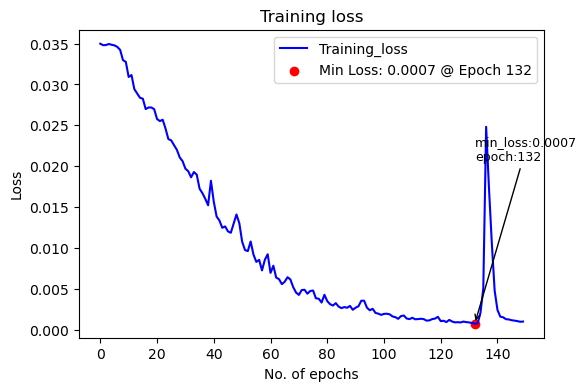

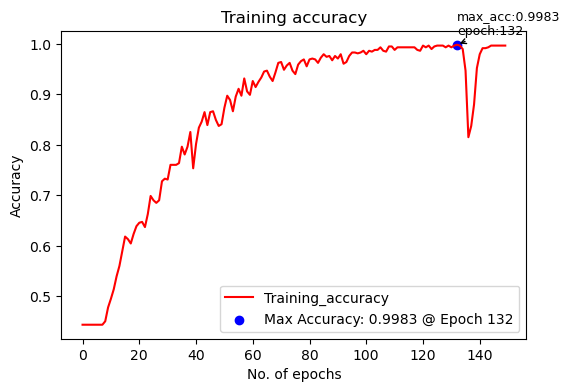

In [314]:
plt_loss_accuracy_fig(total_train_loss, total_train_acc)

Load pth from GRU_model_text.pth


100%|██████████| 19/19 [00:00<00:00, 385.97it/s]

Top-1 Accuracy: 0.9966


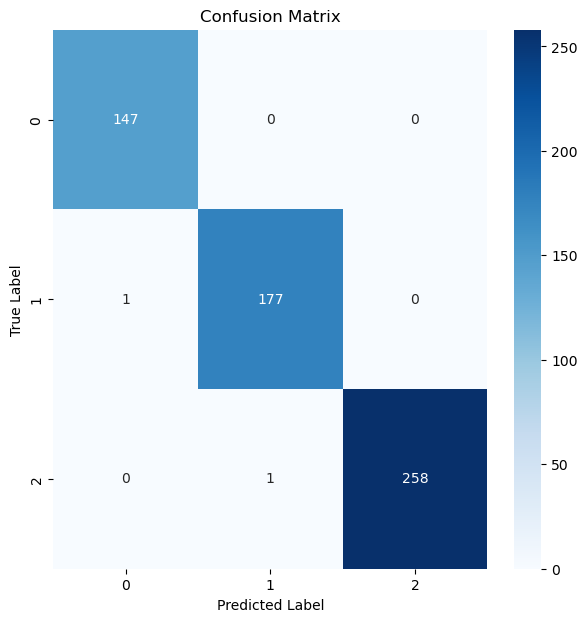

In [315]:
# Load back the model
GRU_model = GRU_model_text().to(device)

pth_path = 'GRU_model_text.pth'
state_dict = torch.load(pth_path)
GRU_model.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")

total_train_probs, train_pred_labels, true_labels = test(train_dataloader, GRU_model, type="train")

top_1_acc = 0.0
num_samples = len(true_labels)

for probs, label in zip(total_train_probs, true_labels):
    # Get top 3 predictions
    top3_probs, top3_indices = torch.topk(probs, 3, dim=0, largest=True, sorted=True)

    # Top-1 accuracy: if the top-1 predicted class matches the true label
    if top3_indices[0] == label:
        top_1_acc += 1


# Calculate the final accuracy
top_1_acc /= num_samples

print(f"Top-1 Accuracy: {top_1_acc:.4f}")
plot_confusion_matrix(train_pred_labels, true_labels)

### 5. Develop an RNN model that can predict the remaining words of a sentence based on the initial words you input. 
#### Use RNN model to generate the text.
* RNN model:
    * input: a fixed length sequence
    * output: a map of each token, and choose the token with max probability   
    * training process: x is a fixed length sequence, and y is a next token.  

    
**The predicted sentence should closely resemble one of the provided texts.**

### 5.1. Preprocess the dataset into separate sequence with fixed size.
Let `FIXED_SEQ_LEN = 5`  
e.g. **I'm just trying to keep my head above water -> I 'm just trying to keep my head above water**  
0 0 0 I 'm   
0 0 I 'm just  
0 I 'm just trying  
.  
.  
.  
* 5th token is next token
* ALL messages combine into a big context.

In [354]:
FIXED_SEQ_LEN = 6 # must >= 2
END_TOKEN = '<END>'
ZERO_TOKEN = '<ZERO>'
# add new key
total_sequences = []
for seq in data_dict['message']:
    temp_seq = [ZERO_TOKEN] * (FIXED_SEQ_LEN - 2) + seq + [END_TOKEN] # padding in the beginning, and adding END token to train
    for i in range(0, len(temp_seq)-FIXED_SEQ_LEN+1):
        total_sequences.append(temp_seq[i:i+FIXED_SEQ_LEN])
# see the result
print(total_sequences[:10])
print(len(total_sequences))

[['<ZERO>', '<ZERO>', '<ZERO>', '<ZERO>', 'i', 'really'], ['<ZERO>', '<ZERO>', '<ZERO>', 'i', 'really', 'enjoyed'], ['<ZERO>', '<ZERO>', 'i', 'really', 'enjoyed', 'the'], ['<ZERO>', 'i', 'really', 'enjoyed', 'the', 'movie'], ['i', 'really', 'enjoyed', 'the', 'movie', '<END>'], ['<ZERO>', '<ZERO>', '<ZERO>', '<ZERO>', 'the', 'food'], ['<ZERO>', '<ZERO>', '<ZERO>', 'the', 'food', 'was'], ['<ZERO>', '<ZERO>', 'the', 'food', 'was', 'terrible'], ['<ZERO>', 'the', 'food', 'was', 'terrible', '<END>'], ['<ZERO>', '<ZERO>', '<ZERO>', '<ZERO>', 'i', "'m"]]
4643


In [355]:
# Hyper Parameters
LR_2 = 0.01
batch_size_train_2 = 8
NUM_EPOCHS_2 = 150
# Step 1: Convert numpy array to list and add END_TOKEN
all_tokens_list = all_tokens.tolist()
all_tokens_list.append(END_TOKEN)

# Step 2: Manually count frequency of each token
token_freq = {}
for token in all_tokens_list:
    if token in token_freq:
        token_freq[token] += 1
    else:
        token_freq[token] = 1

# Step 3: Sort tokens by frequency (descending)
sorted_tokens = sorted(token_freq.items(), key=lambda x: x[1], reverse=True)

# Step 4: Create token-to-index and index-to-token tables
token2idx_table = {token: idx for idx, (token, _) in enumerate(sorted_tokens)}
idx2token_table = {idx: token for token, idx in token2idx_table.items()}

# Step 5: Output dimension is number of unique tokens
OUTPUT_DIMENSION = len(token2idx_table)

# Step 6: Print
print(f"OUTPUT_DIMENSION is {OUTPUT_DIMENSION}.")
print(f"Index of END_TOKEN is {token2idx_table[END_TOKEN]}")
print("Token2Idx Table:", token2idx_table)

OUTPUT_DIMENSION is 842.
Index of END_TOKEN is 841
Token2Idx Table: {'i': 0, 'the': 1, "'m": 2, 'this': 3, 'was': 4, 'a': 5, 'is': 6, 'my': 7, 'to': 8, 'and': 9, 'just': 10, 'so': 11, 'not': 12, 'feeling': 13, 'with': 14, 'at': 15, 'for': 16, 'have': 17, 'in': 18, "n't": 19, 'sure': 20, 'about': 21, 'do': 22, 'on': 23, 'average': 24, 'today': 25, 'service': 26, 'of': 27, 'bit': 28, 'product': 29, 'hotel': 30, 'out': 31, 'got': 32, 'if': 33, 'food': 34, 'time': 35, 'no': 36, 'new': 37, 'movie': 38, 'love': 39, 'what': 40, 'work': 41, 'trying': 42, 'from': 43, 'standard': 44, 'that': 45, 'life': 46, 'really': 47, 'great': 48, 'weather': 49, 'here': 50, 'restaurant': 51, '🤔': 52, 'things': 53, '😔': 54, 'hate': 55, 'terrible': 56, 'had': 57, 'car': 58, 'it': 59, 'book': 60, 'phone': 61, 'grateful': 62, '😞': 63, 'amazing': 64, 'very': 65, 'company': 66, 'strong': 67, 'happy': 68, 'right': 69, 'going': 70, 'now': 71, 'how': 72, 'museum': 73, 'an': 74, 'beach': 75, 'excellent': 76, 'traffic':

### 5.2. Create the dataset.

In [356]:
class GENTextDataset(Dataset):
    def __init__(self, total_sequences, token2idx_table, model_Word2Vec):
        self.total_sequences = total_sequences
        self.token2idx_table = token2idx_table
        self.model_Word2Vec = model_Word2Vec
        self.num_samples = len(self.total_sequences)
        self.zero_vector = np.zeros(self.model_Word2Vec.vector_size)
    def __getitem__(self,idx):
        seq = self.total_sequences[idx]
        # get next token string
        next_token = seq[FIXED_SEQ_LEN-1]
        # get the index 
        next_token = token2idx_table[next_token]

        vector = []
        for token in seq[:FIXED_SEQ_LEN-1]:
            if token in self.model_Word2Vec.wv:
                vec = self.model_Word2Vec.wv[token]
            else:
                vec = self.zero_vector  # handle OOV (ZERO_TOKEN & END_TOKEN)
            vector.append(vec)
        # assign input and output
        pre_seq = vector
        
        # Convert to tensor
        pre_seq = torch.tensor(np.array(pre_seq), dtype=torch.float32)
        next_token = torch.tensor(next_token, dtype=torch.long)
        return pre_seq, next_token

    def __len__(self):
        return self.num_samples

def get_one_batch(pre_seq, model_Word2Vec):
    '''
    pre_seq is a list.
    convert it into a batch with word vector
    '''
    # UNKNOWN vector
    zero_vector = np.zeros(model_Word2Vec.vector_size)
    vector = []
    for token in pre_seq:
        if token in model_Word2Vec.wv:
            vec = model_Word2Vec.wv[token]
        else:
            vec = zero_vector  # handle OOV (ZERO_TOKEN & END_TOKEN)
        vector.append(vec)
    
    # Convert to tensor
    pre_seq = torch.tensor(np.array(vector), dtype=torch.float32)
    pre_seq = torch.unsqueeze(pre_seq, dim=0) # (SEQ_LEN, Hin) - > (Batch_size, SEQ_LEN, Hin)
    return pre_seq

In [357]:
len(total_sequences)

4643

In [358]:
GEN_train_dataset = GENTextDataset(total_sequences, token2idx_table, model_Word2Vec)

print("length of train_dataset:", len(GEN_train_dataset))
GEN_train_dataloader = DataLoader(GEN_train_dataset, batch_size=batch_size_train_2, shuffle=True, pin_memory=True)

length of train_dataset: 4643


In [359]:
# see if it works
for x, y in GEN_train_dataloader:
    print(x.shape, y.shape)
    print(x, y)
    break

torch.Size([8, 5, 50]) torch.Size([8])
tensor([[[ 0.0236,  0.0049,  0.0033,  ..., -0.0164,  0.0012,  0.0101],
         [-0.0012,  0.0066, -0.0356,  ..., -0.0360,  0.0406,  0.0139],
         [-0.0062, -0.0049, -0.0138,  ..., -0.0248,  0.0126,  0.0231],
         [ 0.0082,  0.0291, -0.0285,  ..., -0.0342,  0.0406,  0.0082],
         [-0.0025,  0.0042, -0.0055,  ..., -0.0145,  0.0306,  0.0025]],

        [[-0.0124, -0.0145,  0.0113,  ..., -0.0118, -0.0065,  0.0160],
         [-0.0028,  0.0334, -0.0179,  ..., -0.0219,  0.0248,  0.0107],
         [ 0.0289,  0.0024, -0.0253,  ..., -0.0337,  0.0148,  0.0139],
         [ 0.0087,  0.0427, -0.0407,  ..., -0.0512,  0.0462,  0.0239],
         [-0.0082,  0.0179,  0.0091,  ...,  0.0126, -0.0001,  0.0007]],

        [[ 0.0205, -0.0030, -0.0070,  ..., -0.0450,  0.0366,  0.0034],
         [-0.0110,  0.0057,  0.0182,  ...,  0.0183, -0.0130,  0.0153],
         [ 0.0249, -0.0132,  0.0059,  ..., -0.0225,  0.0238, -0.0025],
         [ 0.0020,  0.0248, -0.036

### 5.3. Create the model.

In [360]:
OUTPUT_DIMENSION

842

In [361]:
# define RNN model
class GRU_model_GENtext(nn.Module):
    def __init__(self):
        super(GRU_model_GENtext, self).__init__()
        self.gru_layers = nn.GRU(Hin, 128, num_layers = 1, batch_first = True) # (input size, output size)
        
        self.classifier_layers = nn.Sequential(
                # Flatten layers
                nn.Linear(128, 256),
                nn.ReLU(),
                nn.Linear(256, 512),
                nn.ReLU(),
                nn.Linear(512, OUTPUT_DIMENSION)
            )
        
    def forward(self, x):
        output, hn = self.gru_layers(x) # output shape is (N,L,D∗Hout) 

        # Try just see the final time step output
        x = output[:, -1, :]  # get last time step (batch_size, H_out)
        # print("CCC", x.shape) 
        x = self.classifier_layers(x)
        return x

In [362]:
GENGRU_model = GRU_model_GENtext().to(device)

# pth_path = 'HW3_2_GENtext_model_GRU.pth'
# state_dict = torch.load(pth_path)
# LSTM_model.load_state_dict(state_dict)
# print(f"Load pth from {pth_path}")

# set loss function
criterion = nn.CrossEntropyLoss()
# set optimizer
optimizer = torch.optim.Adam(GENGRU_model.parameters(), lr=LR)
# Print the model summary
summary(GENGRU_model, (1, FIXED_SEQ_LEN-1, Hin)) # Input size: (height, width)

Layer (type:depth-idx)                   Output Shape              Param #
GRU_model_GENtext                        [1, 842]                  --
├─GRU: 1-1                               [1, 5, 128]               69,120
├─Sequential: 1-2                        [1, 842]                  --
│    └─Linear: 2-1                       [1, 256]                  33,024
│    └─ReLU: 2-2                         [1, 256]                  --
│    └─Linear: 2-3                       [1, 512]                  131,584
│    └─ReLU: 2-4                         [1, 512]                  --
│    └─Linear: 2-5                       [1, 842]                  431,946
Total params: 665,674
Trainable params: 665,674
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.94
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.66
Estimated Total Size (MB): 2.68

### 5.4. Design the training and predicting process.

In [363]:
from tqdm import tqdm
# train and val func for one epoch
def GEN_train_epoch(train_dataloader, model):
    train_loss = 0.0
    train_acc = 0.0
    model.train()
    for x, y in tqdm(train_dataloader):
        x, y = x.to(device), y.to(device)
        # clear gradients
        optimizer.zero_grad()
        # predicting
        y_pred = model(x)
        # see loss
        loss = criterion(y_pred, y)
        loss.backward()
        
        # update the parameters
        optimizer.step()

        train_loss += loss.item()
        probs = torch.nn.functional.softmax(y_pred, dim=1)
        train_acc += torch.sum(torch.argmax(probs, dim=1) == y).item()
    return train_acc / len(train_dataloader.dataset), train_loss / len(train_dataloader.dataset)

def sample(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype('float64')
    predictions = np.log(predictions + 1e-10) / temperature
    exp_preds = np.exp(predictions)
    predictions = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(predictions), p=predictions)


def GEN_next_token(batch, model, temperature=1.0):
    model.eval()
    with torch.no_grad():
        batch = batch.to(device)
        y_pred = model(batch)  # shape: [1, vocab_size]
        probs = torch.nn.functional.softmax(y_pred[0], dim=0)  # take the first sample
        probs_np = probs.cpu().numpy()  # convert to numpy
        idx = sample(probs_np, temperature=temperature)
        return idx2token_table[idx]
    
def GEN_sentences(first_token, model, temperature=1.0):
    sentences = [first_token]
    model.eval()
    MAX_STEP = 30 # maximum length of sentence
    next_token = ZERO_TOKEN
    # initial pre_seq
    # padding ZERO_TOKEN in the beginning
    pre_seq = [ZERO_TOKEN]*(FIXED_SEQ_LEN-2) + [first_token] # len of pre_seq is FIXED_SEQ_LEN-1
    with torch.no_grad():
        count = 0
        while next_token != END_TOKEN and count < MAX_STEP:
            batch = get_one_batch(pre_seq, model_Word2Vec)
            next_token = GEN_next_token(batch, model, temperature=temperature)
            count += 1
            # update the pre_seq for next prediction
            pre_seq = pre_seq[1:] + [next_token]
            
            if next_token != END_TOKEN and count < MAX_STEP:
                sentences.append(next_token)
    print("Sentences length: ", len(sentences))
    return sentences
        

### 5.5 Training...

In [364]:
# Start training and testing
max_accuracy = 0
# For ploting the trend image
total_train_acc = []
total_train_loss = []
for i in range(NUM_EPOCHS_2):
    train_acc, train_loss = GEN_train_epoch(train_dataloader, GENGRU_model)
    # record the training data
    total_train_acc.append(train_acc)

    total_train_loss.append(train_loss)

    print("Epoch[{:>2d}/{:>2d}] : train_acc = {:.4f}, train_loss = {:.4f}".format(i+1, NUM_EPOCHS_2, train_acc, train_loss))
    # update model pth when larger val_acc happens
    if(train_acc > max_accuracy):
        max_accuracy = train_acc
        save_parameters = True
        if save_parameters:
            path = 'GRU_model_GENtext.pth'
            torch.save(GENGRU_model.state_dict(), path)
            print("\t\33[33m====Save model parameters in {:s} when val_acc is {:.4f}====\33[0m".format(path, train_acc))

# save the final epoch's model
path = 'GRU_model_GENtext_final_epoch.pth'
torch.save(GENGRU_model.state_dict(), path)
print("\t\33[33m====Save FINAL model parameters in {:s}====\33[0m".format(path))

100%|██████████| 19/19 [00:00<00:00, 127.11it/s]


Epoch[ 1/150] : train_acc = 0.3904, train_loss = 0.1538
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.3904====


100%|██████████| 19/19 [00:00<00:00, 146.74it/s]


Epoch[ 2/150] : train_acc = 0.3801, train_loss = 0.0417


100%|██████████| 19/19 [00:00<00:00, 191.74it/s]


Epoch[ 3/150] : train_acc = 0.3699, train_loss = 0.0371


100%|██████████| 19/19 [00:00<00:00, 172.71it/s]


Epoch[ 4/150] : train_acc = 0.4435, train_loss = 0.0350
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.4435====


100%|██████████| 19/19 [00:00<00:00, 209.65it/s]


Epoch[ 5/150] : train_acc = 0.4435, train_loss = 0.0349


100%|██████████| 19/19 [00:00<00:00, 205.56it/s]


Epoch[ 6/150] : train_acc = 0.4435, train_loss = 0.0350


100%|██████████| 19/19 [00:00<00:00, 184.05it/s]


Epoch[ 7/150] : train_acc = 0.4435, train_loss = 0.0352


100%|██████████| 19/19 [00:00<00:00, 194.18it/s]


Epoch[ 8/150] : train_acc = 0.4435, train_loss = 0.0351


100%|██████████| 19/19 [00:00<00:00, 184.63it/s]


Epoch[ 9/150] : train_acc = 0.4435, train_loss = 0.0350


100%|██████████| 19/19 [00:00<00:00, 211.18it/s]


Epoch[10/150] : train_acc = 0.4435, train_loss = 0.0352


100%|██████████| 19/19 [00:00<00:00, 216.68it/s]


Epoch[11/150] : train_acc = 0.4435, train_loss = 0.0349


100%|██████████| 19/19 [00:00<00:00, 200.61it/s]


Epoch[12/150] : train_acc = 0.4435, train_loss = 0.0350


100%|██████████| 19/19 [00:00<00:00, 176.56it/s]


Epoch[13/150] : train_acc = 0.3801, train_loss = 0.0358


100%|██████████| 19/19 [00:00<00:00, 205.40it/s]


Epoch[14/150] : train_acc = 0.4435, train_loss = 0.0349


100%|██████████| 19/19 [00:00<00:00, 204.79it/s]


Epoch[15/150] : train_acc = 0.4435, train_loss = 0.0352


100%|██████████| 19/19 [00:00<00:00, 202.83it/s]


Epoch[16/150] : train_acc = 0.4435, train_loss = 0.0350


100%|██████████| 19/19 [00:00<00:00, 214.04it/s]


Epoch[17/150] : train_acc = 0.4435, train_loss = 0.0350


100%|██████████| 19/19 [00:00<00:00, 204.25it/s]


Epoch[18/150] : train_acc = 0.4435, train_loss = 0.0353


100%|██████████| 19/19 [00:00<00:00, 218.34it/s]


Epoch[19/150] : train_acc = 0.4435, train_loss = 0.0349


100%|██████████| 19/19 [00:00<00:00, 215.10it/s]


Epoch[20/150] : train_acc = 0.4435, train_loss = 0.0350


100%|██████████| 19/19 [00:00<00:00, 201.97it/s]


Epoch[21/150] : train_acc = 0.4435, train_loss = 0.0354


100%|██████████| 19/19 [00:00<00:00, 206.29it/s]


Epoch[22/150] : train_acc = 0.4435, train_loss = 0.0353


100%|██████████| 19/19 [00:00<00:00, 205.51it/s]


Epoch[23/150] : train_acc = 0.4435, train_loss = 0.0353


100%|██████████| 19/19 [00:00<00:00, 216.78it/s]


Epoch[24/150] : train_acc = 0.4315, train_loss = 0.0354


100%|██████████| 19/19 [00:00<00:00, 199.72it/s]


Epoch[25/150] : train_acc = 0.4435, train_loss = 0.0348


100%|██████████| 19/19 [00:00<00:00, 204.88it/s]


Epoch[26/150] : train_acc = 0.4435, train_loss = 0.0352


100%|██████████| 19/19 [00:00<00:00, 209.94it/s]


Epoch[27/150] : train_acc = 0.4435, train_loss = 0.0351


100%|██████████| 19/19 [00:00<00:00, 211.24it/s]


Epoch[28/150] : train_acc = 0.4092, train_loss = 0.0352


100%|██████████| 19/19 [00:00<00:00, 210.83it/s]


Epoch[29/150] : train_acc = 0.4435, train_loss = 0.0349


100%|██████████| 19/19 [00:00<00:00, 218.89it/s]


Epoch[30/150] : train_acc = 0.4401, train_loss = 0.0353


100%|██████████| 19/19 [00:00<00:00, 200.77it/s]


Epoch[31/150] : train_acc = 0.4435, train_loss = 0.0352


100%|██████████| 19/19 [00:00<00:00, 190.15it/s]


Epoch[32/150] : train_acc = 0.4435, train_loss = 0.0351


100%|██████████| 19/19 [00:00<00:00, 170.50it/s]


Epoch[33/150] : train_acc = 0.4435, train_loss = 0.0348


100%|██████████| 19/19 [00:00<00:00, 198.79it/s]


Epoch[34/150] : train_acc = 0.4435, train_loss = 0.0347


100%|██████████| 19/19 [00:00<00:00, 198.07it/s]


Epoch[35/150] : train_acc = 0.4435, train_loss = 0.0350


100%|██████████| 19/19 [00:00<00:00, 189.76it/s]


Epoch[36/150] : train_acc = 0.4435, train_loss = 0.0351


100%|██████████| 19/19 [00:00<00:00, 192.96it/s]


Epoch[37/150] : train_acc = 0.4435, train_loss = 0.0348


100%|██████████| 19/19 [00:00<00:00, 220.28it/s]


Epoch[38/150] : train_acc = 0.4435, train_loss = 0.0346


100%|██████████| 19/19 [00:00<00:00, 215.41it/s]


Epoch[39/150] : train_acc = 0.4435, train_loss = 0.0348


100%|██████████| 19/19 [00:00<00:00, 206.59it/s]


Epoch[40/150] : train_acc = 0.4435, train_loss = 0.0345


100%|██████████| 19/19 [00:00<00:00, 187.58it/s]


Epoch[41/150] : train_acc = 0.4435, train_loss = 0.0345


100%|██████████| 19/19 [00:00<00:00, 186.76it/s]


Epoch[42/150] : train_acc = 0.4435, train_loss = 0.0341


100%|██████████| 19/19 [00:00<00:00, 196.03it/s]


Epoch[43/150] : train_acc = 0.4452, train_loss = 0.0342
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.4452====


100%|██████████| 19/19 [00:00<00:00, 202.15it/s]


Epoch[44/150] : train_acc = 0.4281, train_loss = 0.0339


100%|██████████| 19/19 [00:00<00:00, 216.10it/s]


Epoch[45/150] : train_acc = 0.4418, train_loss = 0.0338


100%|██████████| 19/19 [00:00<00:00, 216.91it/s]


Epoch[46/150] : train_acc = 0.4829, train_loss = 0.0321
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.4829====


100%|██████████| 19/19 [00:00<00:00, 224.05it/s]


Epoch[47/150] : train_acc = 0.4743, train_loss = 0.0322


100%|██████████| 19/19 [00:00<00:00, 166.84it/s]


Epoch[48/150] : train_acc = 0.5154, train_loss = 0.0309
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.5154====


100%|██████████| 19/19 [00:00<00:00, 180.10it/s]


Epoch[49/150] : train_acc = 0.5205, train_loss = 0.0303
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.5205====


100%|██████████| 19/19 [00:00<00:00, 209.96it/s]


Epoch[50/150] : train_acc = 0.5188, train_loss = 0.0299


100%|██████████| 19/19 [00:00<00:00, 199.11it/s]


Epoch[51/150] : train_acc = 0.5171, train_loss = 0.0305


100%|██████████| 19/19 [00:00<00:00, 207.33it/s]


Epoch[52/150] : train_acc = 0.5154, train_loss = 0.0311


100%|██████████| 19/19 [00:00<00:00, 215.31it/s]


Epoch[53/150] : train_acc = 0.5205, train_loss = 0.0293


100%|██████████| 19/19 [00:00<00:00, 212.04it/s]


Epoch[54/150] : train_acc = 0.5599, train_loss = 0.0289
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.5599====


100%|██████████| 19/19 [00:00<00:00, 183.12it/s]


Epoch[55/150] : train_acc = 0.5599, train_loss = 0.0285


100%|██████████| 19/19 [00:00<00:00, 167.97it/s]


Epoch[56/150] : train_acc = 0.5856, train_loss = 0.0282
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.5856====


100%|██████████| 19/19 [00:00<00:00, 194.28it/s]


Epoch[57/150] : train_acc = 0.5634, train_loss = 0.0286


100%|██████████| 19/19 [00:00<00:00, 172.64it/s]


Epoch[58/150] : train_acc = 0.6130, train_loss = 0.0281
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.6130====


100%|██████████| 19/19 [00:00<00:00, 180.95it/s]


Epoch[59/150] : train_acc = 0.5890, train_loss = 0.0270


100%|██████████| 19/19 [00:00<00:00, 181.02it/s]


Epoch[60/150] : train_acc = 0.6010, train_loss = 0.0275


100%|██████████| 19/19 [00:00<00:00, 192.48it/s]


Epoch[61/150] : train_acc = 0.5959, train_loss = 0.0262


100%|██████████| 19/19 [00:00<00:00, 211.02it/s]


Epoch[62/150] : train_acc = 0.6301, train_loss = 0.0258
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.6301====


100%|██████████| 19/19 [00:00<00:00, 171.64it/s]


Epoch[63/150] : train_acc = 0.6404, train_loss = 0.0249
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.6404====


100%|██████████| 19/19 [00:00<00:00, 185.31it/s]


Epoch[64/150] : train_acc = 0.6541, train_loss = 0.0245
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.6541====


100%|██████████| 19/19 [00:00<00:00, 195.10it/s]


Epoch[65/150] : train_acc = 0.6284, train_loss = 0.0246


100%|██████████| 19/19 [00:00<00:00, 168.34it/s]


Epoch[66/150] : train_acc = 0.6455, train_loss = 0.0251


100%|██████████| 19/19 [00:00<00:00, 156.42it/s]


Epoch[67/150] : train_acc = 0.6524, train_loss = 0.0250


100%|██████████| 19/19 [00:00<00:00, 200.28it/s]


Epoch[68/150] : train_acc = 0.6781, train_loss = 0.0234
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.6781====


100%|██████████| 19/19 [00:00<00:00, 200.77it/s]


Epoch[69/150] : train_acc = 0.6370, train_loss = 0.0242


100%|██████████| 19/19 [00:00<00:00, 169.04it/s]


Epoch[70/150] : train_acc = 0.6558, train_loss = 0.0239


100%|██████████| 19/19 [00:00<00:00, 170.67it/s]


Epoch[71/150] : train_acc = 0.7089, train_loss = 0.0227
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.7089====


100%|██████████| 19/19 [00:00<00:00, 205.98it/s]


Epoch[72/150] : train_acc = 0.6866, train_loss = 0.0225


100%|██████████| 19/19 [00:00<00:00, 204.23it/s]


Epoch[73/150] : train_acc = 0.7038, train_loss = 0.0229


100%|██████████| 19/19 [00:00<00:00, 211.72it/s]


Epoch[74/150] : train_acc = 0.7106, train_loss = 0.0209
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.7106====


100%|██████████| 19/19 [00:00<00:00, 177.55it/s]


Epoch[75/150] : train_acc = 0.7055, train_loss = 0.0213


100%|██████████| 19/19 [00:00<00:00, 176.62it/s]


Epoch[76/150] : train_acc = 0.7312, train_loss = 0.0208
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.7312====


100%|██████████| 19/19 [00:00<00:00, 179.04it/s]


Epoch[77/150] : train_acc = 0.7363, train_loss = 0.0197
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.7363====


100%|██████████| 19/19 [00:00<00:00, 185.91it/s]


Epoch[78/150] : train_acc = 0.7534, train_loss = 0.0193
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.7534====


100%|██████████| 19/19 [00:00<00:00, 185.20it/s]


Epoch[79/150] : train_acc = 0.7380, train_loss = 0.0204


100%|██████████| 19/19 [00:00<00:00, 192.22it/s]


Epoch[80/150] : train_acc = 0.7277, train_loss = 0.0207


100%|██████████| 19/19 [00:00<00:00, 187.58it/s]


Epoch[81/150] : train_acc = 0.7825, train_loss = 0.0181
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.7825====


100%|██████████| 19/19 [00:00<00:00, 180.83it/s]


Epoch[82/150] : train_acc = 0.7603, train_loss = 0.0177


100%|██████████| 19/19 [00:00<00:00, 195.04it/s]


Epoch[83/150] : train_acc = 0.7842, train_loss = 0.0178
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.7842====


100%|██████████| 19/19 [00:00<00:00, 185.74it/s]


Epoch[84/150] : train_acc = 0.8031, train_loss = 0.0164
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.8031====


100%|██████████| 19/19 [00:00<00:00, 190.86it/s]


Epoch[85/150] : train_acc = 0.8099, train_loss = 0.0153
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.8099====


100%|██████████| 19/19 [00:00<00:00, 193.93it/s]


Epoch[86/150] : train_acc = 0.8065, train_loss = 0.0154


100%|██████████| 19/19 [00:00<00:00, 165.75it/s]


Epoch[87/150] : train_acc = 0.8065, train_loss = 0.0160


100%|██████████| 19/19 [00:00<00:00, 188.47it/s]


Epoch[88/150] : train_acc = 0.8219, train_loss = 0.0147
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.8219====


100%|██████████| 19/19 [00:00<00:00, 190.46it/s]


Epoch[89/150] : train_acc = 0.8476, train_loss = 0.0140
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.8476====


100%|██████████| 19/19 [00:00<00:00, 190.90it/s]


Epoch[90/150] : train_acc = 0.8185, train_loss = 0.0142


100%|██████████| 19/19 [00:00<00:00, 186.71it/s]


Epoch[91/150] : train_acc = 0.8339, train_loss = 0.0136


100%|██████████| 19/19 [00:00<00:00, 177.20it/s]


Epoch[92/150] : train_acc = 0.8527, train_loss = 0.0123
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.8527====


100%|██████████| 19/19 [00:00<00:00, 198.95it/s]


Epoch[93/150] : train_acc = 0.8219, train_loss = 0.0149


100%|██████████| 19/19 [00:00<00:00, 186.86it/s]


Epoch[94/150] : train_acc = 0.8236, train_loss = 0.0149


100%|██████████| 19/19 [00:00<00:00, 164.61it/s]


Epoch[95/150] : train_acc = 0.8545, train_loss = 0.0128
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.8545====


100%|██████████| 19/19 [00:00<00:00, 200.38it/s]


Epoch[96/150] : train_acc = 0.8596, train_loss = 0.0125
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.8596====


100%|██████████| 19/19 [00:00<00:00, 189.74it/s]


Epoch[97/150] : train_acc = 0.8596, train_loss = 0.0129


100%|██████████| 19/19 [00:00<00:00, 199.76it/s]


Epoch[98/150] : train_acc = 0.8630, train_loss = 0.0116
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.8630====


100%|██████████| 19/19 [00:00<00:00, 197.73it/s]


Epoch[99/150] : train_acc = 0.8853, train_loss = 0.0105
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.8853====


100%|██████████| 19/19 [00:00<00:00, 203.35it/s]


Epoch[100/150] : train_acc = 0.8647, train_loss = 0.0117


100%|██████████| 19/19 [00:00<00:00, 192.66it/s]


Epoch[101/150] : train_acc = 0.8699, train_loss = 0.0120


100%|██████████| 19/19 [00:00<00:00, 191.51it/s]


Epoch[102/150] : train_acc = 0.8870, train_loss = 0.0106
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.8870====


100%|██████████| 19/19 [00:00<00:00, 193.47it/s]


Epoch[103/150] : train_acc = 0.8904, train_loss = 0.0097
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.8904====


100%|██████████| 19/19 [00:00<00:00, 202.87it/s]


Epoch[104/150] : train_acc = 0.8955, train_loss = 0.0092
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.8955====


100%|██████████| 19/19 [00:00<00:00, 193.32it/s]


Epoch[105/150] : train_acc = 0.9058, train_loss = 0.0092
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9058====


100%|██████████| 19/19 [00:00<00:00, 184.74it/s]


Epoch[106/150] : train_acc = 0.9264, train_loss = 0.0085
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9264====


100%|██████████| 19/19 [00:00<00:00, 194.70it/s]


Epoch[107/150] : train_acc = 0.9229, train_loss = 0.0082


100%|██████████| 19/19 [00:00<00:00, 201.32it/s]


Epoch[108/150] : train_acc = 0.9144, train_loss = 0.0092


100%|██████████| 19/19 [00:00<00:00, 211.47it/s]


Epoch[109/150] : train_acc = 0.9092, train_loss = 0.0086


100%|██████████| 19/19 [00:00<00:00, 172.46it/s]


Epoch[110/150] : train_acc = 0.9178, train_loss = 0.0080


100%|██████████| 19/19 [00:00<00:00, 196.15it/s]


Epoch[111/150] : train_acc = 0.9195, train_loss = 0.0073


100%|██████████| 19/19 [00:00<00:00, 207.92it/s]


Epoch[112/150] : train_acc = 0.9315, train_loss = 0.0073
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9315====


100%|██████████| 19/19 [00:00<00:00, 183.29it/s]


Epoch[113/150] : train_acc = 0.9212, train_loss = 0.0073


100%|██████████| 19/19 [00:00<00:00, 194.57it/s]


Epoch[114/150] : train_acc = 0.8955, train_loss = 0.0083


100%|██████████| 19/19 [00:00<00:00, 187.00it/s]


Epoch[115/150] : train_acc = 0.9349, train_loss = 0.0068
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9349====


100%|██████████| 19/19 [00:00<00:00, 200.28it/s]


Epoch[116/150] : train_acc = 0.9315, train_loss = 0.0072


100%|██████████| 19/19 [00:00<00:00, 205.41it/s]


Epoch[117/150] : train_acc = 0.9281, train_loss = 0.0071


100%|██████████| 19/19 [00:00<00:00, 197.13it/s]


Epoch[118/150] : train_acc = 0.9366, train_loss = 0.0066
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9366====


100%|██████████| 19/19 [00:00<00:00, 198.41it/s]


Epoch[119/150] : train_acc = 0.9435, train_loss = 0.0065
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9435====


100%|██████████| 19/19 [00:00<00:00, 203.54it/s]


Epoch[120/150] : train_acc = 0.9144, train_loss = 0.0080


100%|██████████| 19/19 [00:00<00:00, 188.78it/s]


Epoch[121/150] : train_acc = 0.9349, train_loss = 0.0062


100%|██████████| 19/19 [00:00<00:00, 185.66it/s]


Epoch[122/150] : train_acc = 0.9503, train_loss = 0.0055
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9503====


100%|██████████| 19/19 [00:00<00:00, 168.87it/s]


Epoch[123/150] : train_acc = 0.9469, train_loss = 0.0054


100%|██████████| 19/19 [00:00<00:00, 184.04it/s]


Epoch[124/150] : train_acc = 0.9435, train_loss = 0.0055


100%|██████████| 19/19 [00:00<00:00, 191.57it/s]


Epoch[125/150] : train_acc = 0.9521, train_loss = 0.0051
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9521====


100%|██████████| 19/19 [00:00<00:00, 202.36it/s]


Epoch[126/150] : train_acc = 0.9555, train_loss = 0.0049
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9555====


100%|██████████| 19/19 [00:00<00:00, 198.60it/s]


Epoch[127/150] : train_acc = 0.9589, train_loss = 0.0049
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9589====


100%|██████████| 19/19 [00:00<00:00, 190.03it/s]


Epoch[128/150] : train_acc = 0.9606, train_loss = 0.0042
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9606====


100%|██████████| 19/19 [00:00<00:00, 177.60it/s]


Epoch[129/150] : train_acc = 0.9726, train_loss = 0.0039
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9726====


100%|██████████| 19/19 [00:00<00:00, 172.22it/s]


Epoch[130/150] : train_acc = 0.9777, train_loss = 0.0036
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9777====


100%|██████████| 19/19 [00:00<00:00, 183.81it/s]


Epoch[131/150] : train_acc = 0.9726, train_loss = 0.0037


100%|██████████| 19/19 [00:00<00:00, 192.90it/s]


Epoch[132/150] : train_acc = 0.9692, train_loss = 0.0043


100%|██████████| 19/19 [00:00<00:00, 161.65it/s]


Epoch[133/150] : train_acc = 0.9007, train_loss = 0.0085


100%|██████████| 19/19 [00:00<00:00, 178.84it/s]


Epoch[134/150] : train_acc = 0.9572, train_loss = 0.0045


100%|██████████| 19/19 [00:00<00:00, 186.03it/s]


Epoch[135/150] : train_acc = 0.9692, train_loss = 0.0039


100%|██████████| 19/19 [00:00<00:00, 187.07it/s]


Epoch[136/150] : train_acc = 0.9795, train_loss = 0.0032
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9795====


100%|██████████| 19/19 [00:00<00:00, 191.12it/s]


Epoch[137/150] : train_acc = 0.9760, train_loss = 0.0030


100%|██████████| 19/19 [00:00<00:00, 214.22it/s]


Epoch[138/150] : train_acc = 0.9829, train_loss = 0.0028
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9829====


100%|██████████| 19/19 [00:00<00:00, 190.64it/s]


Epoch[139/150] : train_acc = 0.9675, train_loss = 0.0034


100%|██████████| 19/19 [00:00<00:00, 199.84it/s]


Epoch[140/150] : train_acc = 0.9829, train_loss = 0.0025


100%|██████████| 19/19 [00:00<00:00, 195.03it/s]


Epoch[141/150] : train_acc = 0.9863, train_loss = 0.0023
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9863====


100%|██████████| 19/19 [00:00<00:00, 191.10it/s]


Epoch[142/150] : train_acc = 0.9795, train_loss = 0.0026


100%|██████████| 19/19 [00:00<00:00, 215.04it/s]


Epoch[143/150] : train_acc = 0.9863, train_loss = 0.0025


100%|██████████| 19/19 [00:00<00:00, 202.98it/s]


Epoch[144/150] : train_acc = 0.9829, train_loss = 0.0026


100%|██████████| 19/19 [00:00<00:00, 202.61it/s]


Epoch[145/150] : train_acc = 0.9829, train_loss = 0.0022


100%|██████████| 19/19 [00:00<00:00, 203.39it/s]


Epoch[146/150] : train_acc = 0.9846, train_loss = 0.0020


100%|██████████| 19/19 [00:00<00:00, 198.83it/s]


Epoch[147/150] : train_acc = 0.9863, train_loss = 0.0021


100%|██████████| 19/19 [00:00<00:00, 168.21it/s]


Epoch[148/150] : train_acc = 0.9880, train_loss = 0.0020
	====Save model parameters in GRU_model_GENtext.pth when val_acc is 0.9880====


100%|██████████| 19/19 [00:00<00:00, 202.94it/s]


Epoch[149/150] : train_acc = 0.9863, train_loss = 0.0018


100%|██████████| 19/19 [00:00<00:00, 190.89it/s]

Epoch[150/150] : train_acc = 0.9863, train_loss = 0.0017
	====Save FINAL model parameters in GRU_model_GENtext_final_epoch.pth====


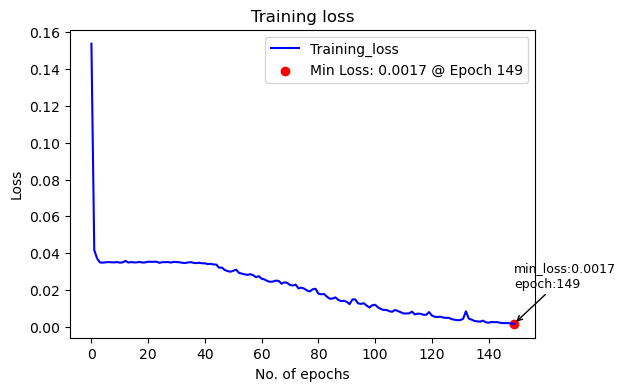

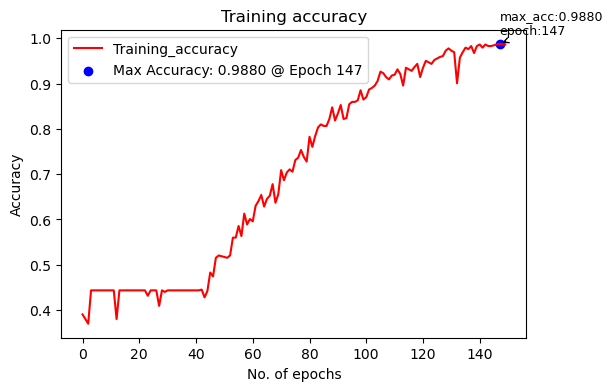

In [365]:
plt_loss_accuracy_fig(total_train_loss, total_train_acc)

### 5.6. Predicting...

In [366]:
# Reload the best model
GENGRU_model = GRU_model_GENtext().to(device)

pth_path = 'GRU_model_GENtext.pth'
state_dict = torch.load(pth_path)
GENGRU_model.load_state_dict(state_dict)
print(f"Load pth from {pth_path}")

Load pth from GRU_model_GENtext.pth


#### 5.6.1. Calculate the scores between context and generated sentences.
* There are two indexes to use:
    * Use BLEU: Word overlap / N-gram
    * Use Cosine Similarity: semantic similarity
        * 1.0 → 完全相同方向（語意非常相似）
        * 0.0 → 完全無關
        * -1.0 → 相反語意（很少見於語言）
* The maximum length of generated sentences is 30.

In [367]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
# for example: 
reference = [['I', 'have', 'a', 'dentist', 'appointment', 'tomorrow', 'at', '2pm']]
candidate = ['I', 'have', 'a', 'dentist', 'appointment', 'tomorrow', '2pm']

score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
print(f"BLEU score: {score:.4f}")

BLEU score: 0.7290


In [369]:
from sklearn.metrics.pairwise import cosine_similarity


# Compute sentence vector using average Word2Vec embeddings
def sentence_vector(tokens, model):
    vecs = [model.wv[token] for token in tokens if token in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(model.vector_size)

# Precompute all sentence vectors from dataset
all_vectors = []
for tokens in data_dict['message']:
    vec = sentence_vector(tokens, model_Word2Vec)
    all_vectors.append(vec)
all_vectors = np.array(all_vectors)  # Shape: (num_sentences, embedding_dim)

# Predict sentences starting from given initial tokens
first_tokens = ['i', 'the', 'this', "week", "can", 'my', 'phone', "i'm", 'we', 'feeling']
for i, first_token in enumerate(first_tokens):
    print("\033[94mCase", i + 1, "\033[0m")

    # Generate a sentence using trained GRU model
    sentences = GEN_sentences(first_token, GENGRU_model, temperature=4.0)
    # Convert generated sentence to string for display
    s = " ".join(sentences)
    print("##################################################")
    print(s)
    print("##################################################")
    
    # Evaluate BLEU score with reference sentences
    score = sentence_bleu(data_dict['message'], sentences, smoothing_function=SmoothingFunction().method1)
    print(f"\033[93mBLEU score: {score:.4f}")

    # ---- Cosine Similarity Comparison ----

    # Get vector representation for the generated sentence
    vec_target = sentence_vector(sentences, model_Word2Vec)

    # Compute cosine similarity with all dataset sentences
    similarities = cosine_similarity([vec_target], all_vectors)[0]

    # Get top 3 most semantically similar sentences
    top_k = 3
    top_k_indices = similarities.argsort()[-top_k:][::-1]

    print("Top similar dataset sentences:")
    for idx in top_k_indices:
        ref_sentence = " ".join(data_dict['message'][idx])
        print(f" Cosine Similarity: {similarities[idx]:.4f} | Sentence: {ref_sentence}")

    print("\033[0m-------------------------------------------------")

Case 1 
Sentences length:  30
##################################################
i i had inspired or the 75000 disneyland 5k the myself while 🔮 i i interest cup enjoy focused i unimpressive thing love picked poisoning the date 'm 🎓 💻
##################################################
BLEU score: 0.0301
Top similar dataset sentences:
 Cosine Similarity: 0.9963 | Sentence: i got a parking ticket while i was at the doctor 's office even though i parked in the designated spot 🚗 🎫
 Cosine Similarity: 0.9953 | Sentence: i 'm sorry i ca n't make it to the party 🎉
 Cosine Similarity: 0.9952 | Sentence: i just found out i did n't get the job i applied for 😢
-------------------------------------------------
Case 2 
Sentences length:  30
##################################################
the puppy care ☕️ night 'm beyond picked the nothing cafe the office i i i journey either the myself zone the 40 year 🏠 🤢 loving 💇‍♀️ highway 🖥️
##################################################
BLEU score: 0.01